## Thoughts

Questions to answer:

Before training:
- 1.1 What are the original probabilities of each image?
- 1.2 Do male images have different probabilities than female images?
- 1.3 Can I differentiate male/female images by their log-probabities? I can look at how the log-probs vary per step.
- 1.4 Can I find a visual pattern when ranking images by total log-prob?
- 1.5 What about when I rank them by log-prob in specific timesteps?
- 1.6 How does the average log-prob vary across steps?
- 1.7 How does the variance of the log-probs vary across steps?
- 1.8 What is the distribution of rewards? And advantages?
- 1.9 Are the rewards consistent with the visual aspect of the images?

Training with a single sampling iteration and multiple training steps:

*About log-prob*
- 2.1 How does the log-prob vary across the epochs for each image?
- 2.2 How does the log-prob rank vary across the epochs for each image?
- 2.3 Did the rank by log-prob change from the original model?
- 2.4 How are the original log-probs correlated with the final log-probs?
- 2.5 Can I find a visual pattern when ranking images by total final log-prob?
- 2.6 If I rank them by difference between final and original log-prob can I see a different behavior between men and women?
- 2.7 Can I notice a correlation beween visual aspect and magnitude of the change between final and original log-prob?
- 2.8 Do samples with more extreme rewards (very high or very low) exhibit more significant shifts in their log-probabilities?

- 2.9 How does the average log-prob vary across epochs - overall and per sex?
- 2.10 How does the variance of the log-probs vary across epochs - overall and per sex?
- 2.11 Can I see the distribution of men and women shifting across the epochs?

- 2.12 How does the log-prob vary across the epochs for each individual step?
- 2.13 Can I see a different behaviors at different steps?
- 2.14 How is the difference between men and women at each step? Maybe plot men - women for each step
- 2.15 Do I see a pattern of increasing log-probs for women and decreasing log-prob for men?


*About the importance ratio*
- 3.1 How does the importance ratio varies across the epochs for each?
- 3.2 Can I tell men and women apart by looking at the above curve?
- 3.3 How does the importance ratio vary across the epochs for each individual step?
- 3.4 Do I see the average importance ratio for men increasing and for women decreasing?
- 3.5 What is the distribution of importance ratios for men and women at each epoch? Do the distributions start to drift throughout the epochs?
- 3.6 What is the variance of the importance ratio at each step?
- 3.7 Do we see steps that don't change much from the original log-prob?
- 3.8 The variance of the importance ratio changes over the epochs?

*About clipping*
- 4.1 What is the distribution of number of clipped ratios per step per epoch? Like, maybe plot a histogram per step, then each bin is an epoch and the height of the bin is the number of samples that had the importance ratio clipped in that step and epoch.
- 4.2 What if I do the above plot but stack two bars: one for women and one for men?
- 4.3 How are the statistics (mean and var) of the log-prob affected if I mask them using a "clipped" mask?
- 4.4 Do I actually see the log-prob curves being smoothed when I remove values that were clipped?

*About the gradients*
- 5.1 Which steps contribute more to the gradients?
- 5.2 How do the gradients vary across epochs? 
- 5.3 Do the gradients from men and women vary differently across steps?
- 5.4 What is the variance of the gradients at each step? Are the gradients very different for each image?
- 5.5 Do male images have more impact on the gradient then female images overall?
- 5.6 What about at each step? Can I spot different gradient behavior between men and women in specific steps?
- 5.7 How does the log prob relate to the gradient?
- 5.8 How sensitive are the gradients to different rewards?
- 5.9 How do changes in gradients impact the log-probs in the next epoch for each image?


*About the final loss*
- 6.1 How does the final loss evolve across training epochs?
- 6.2 Is there a correlation between loss and gradient magnitude?
- 6.3 How does the loss relate to changes in log probabilities?
- 6.4 Does the loss decrease more for male or female samples?
- 6.5 Is there a relationship between importance ratio and loss?
- 6.6 If I mask the final loss by clipping, are the relationships clearer?
- 6.7 Are there specific timesteps that contribute more to the final loss?
- 6.8 How does the variance of the loss change throughout training?
- 6.9 Is the loss more sensitive to changes in early or late diffusion steps?

Some ideas
- Use validation set
- What if I only encourage the model to generate male samples without punishing it for generating female samples?
I would love to see the log-likelihoods of the some intermediate steps of the female samples start to decrease, even without being explicitly punished.

- Look into trajectory bifurcation in diffusion models. Maybe I don't need to generate N whole trajectories. Since the beginning of all the trajectories is just removing basic noise, maybe I could use the same early denoising steps for various images

- I like the ideas of that paper about RL for DLLMs

- I need to review the reward model. Maybe do a 2-step verification.

## Read experiment report

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [41]:
EXPERIMENT_NAME = "reinforce_log_1_sampling_40_epochs_5_prompts_all_steps_grad.csv"


In [42]:
df = pd.read_csv(os.path.join("experiments", EXPERIMENT_NAME))
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

## Utils

In [43]:
def plot_sample(batch, sample, experiment_name):
    image_path = f"{experiment_name}/batch{batch}_sample{sample}.png"
    
    # Check if the image exists
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return
    
    # Load and display the image
    img = plt.imread(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Batch {batch}, Sample {sample}")
    plt.show()
    
    return img

## Create additional columns (run with cautious depending on the experiment)

The `gradient`column represents the current gradient norm. This gradient norm is accumulated across all the steps of a batch.

To estimate the contribution of a given step to the overall gradient, we can do:

```gradient_contribution = current_gradient_norm - previous_gradient_norm```

In [25]:
# Calculate the contribution of each step to the gradient norm 
df['gradient_per_step'] = df.groupby(['epoch', 'batch'])['gradient'].transform(lambda x: x - x.shift().fillna(0))


Get timestep as integer

In [ ]:
# Fix the step column by extracting the integer from the tensor string
# Example: convert "tensor(70)" to 70
import re

def extract_number_from_tensor(tensor_str):
    if isinstance(tensor_str, str) and 'tensor' in tensor_str:
        # Extract the number between parentheses
        match = re.search(r'tensor\((\d+)\)', tensor_str)
        if match:
            return int(match.group(1))
    # If it's already a number or doesn't match the pattern, return as is
    return tensor_str

# Apply the function to convert the step column
df["step"] = df["step"].apply(extract_number_from_tensor)

# Verify the column is now numeric
print(f"Step column dtype after conversion: {df['step'].dtype}")


Each `sampling_epoch` has multiple `epoch`s. The new `overall_epoch` column assings a new overall index to each inner epoch.

In [44]:
inner_epochs = df["epoch"].nunique()
df['overall_epoch'] = df['sampling_epoch'] * inner_epochs + df['epoch'] 

Add column to identify sex

In [45]:
df["sex"] = df["reward"].apply(lambda x: "male" if x>0.5 else "female")

In [ ]:
df["sex"].value_counts()

## 1. Pre-training analysis

### 1.1 What are the original probabilities of each image?

In [ ]:
# Filter for overall_epoch=0
epoch0_df = df[df['overall_epoch'] == 0]

# Group by batch, group, sample and sum the log_prob_old
log_probs_summed = epoch0_df.groupby(['batch', 'group', 'sample'])['log_prob_old'].sum().reset_index()

# Merge with other information (sex and reward)
samples_info = df.drop_duplicates(subset=["batch", "group", "sample"])[["batch", "group", "sample", "sex", "reward", "advantage"]]
samples = pd.merge(samples_info, log_probs_summed, on=['batch', 'group', 'sample'])

samples

In [ ]:
# Import necessary libraries
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


# Function to load and display images for each sample
def load_sample_images(df, experiment_name):
    images = {}
    for _, row in df.iterrows():
        batch = row['batch']
        group = row['group']
        sample = row['sample']
        
        # Construct the filename
        filename = f"batch_{batch}_group_{group}_sample_{sample}.png"
        filepath = os.path.join(experiment_name, filename)
        
        # Try to load the image
        try:
            img = Image.open(filepath)
            images[(batch, group, sample)] = img
        except FileNotFoundError:
            print(f"Image not found: {filepath}")
    
    return images

# Load images for each sample
sample_images = load_sample_images(samples, os.path.join("experiments", EXPERIMENT_NAME[:-4]))

# Sort samples by log_prob_old in descending order
sorted_samples = samples.sort_values(by='log_prob_old', ascending=False)

# Display images sorted by log_prob_old (descending)
n_rows = len(sorted_samples) // 4
fig, axes = plt.subplots(n_rows, 4, figsize=(20, 20))
axes = axes.flatten()

for i, (_, row) in enumerate(sorted_samples.iterrows()):
    batch = row['batch']
    group = row['group']
    sample = row['sample']
    sex = row['sex']
    log_prob = row['log_prob_old']
    
    # Get the image
    img_key = (batch, group, sample)
    if img_key in sample_images:
        axes[i].imshow(np.array(sample_images[img_key]))
        axes[i].set_title(f"Batch {batch}, Group {group}, Sample {sample}\nSex: {sex}\nLog Prob: {log_prob:.2f}", fontsize=12)
        axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, "Image not found", ha='center', va='center')
        axes[i].axis('off')

plt.tight_layout()
plt.show()


### 1.2 Do male images have different probabilities than female images?

In [ ]:
# Plot the log_prob_old distribution by sex
plt.figure(figsize=(8, 4))
sns.boxplot(x='sex', y='log_prob_old', data=samples, hue='sex', palette=['skyblue', 'pink'])
plt.title('Distribution of Log Probabilities by Sex')
plt.ylabel('Log Probability')
plt.xlabel('Sex')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Create a histogram of log probabilities colored by sex
plt.figure(figsize=(8, 4))
for sex_type in ['male', 'female']:
    subset = samples[samples['sex'] == sex_type]
    plt.hist(subset['log_prob_old'], alpha=0.5, label=sex_type, bins=15, color='skyblue' if sex_type == 'male' else 'pink')
plt.title('Histogram of Log Probabilities by Sex')
plt.xlabel('Log Probability')
plt.ylabel('Count')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# Calculate mean and variance of log_prob_old for each sex
log_prob_stats = samples.groupby('sex')['log_prob_old'].agg(['mean', 'var', 'std', 'count'])
print("Log Probability Statistics by Sex:")
print(log_prob_stats)

# Perform t-test to check if the difference is statistically significant
from scipy import stats
male_log_probs = samples[samples['sex'] == 'male']['log_prob_old']
female_log_probs = samples[samples['sex'] == 'female']['log_prob_old']
t_stat, p_value = stats.ttest_ind(male_log_probs, female_log_probs, equal_var=False)

print("\nT-test for difference in log probabilities between sexes:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.8f}")
print(f"Statistically significant difference: {p_value < 0.05}")


### 1.3 Can I differentiate male/female images by their log-probabities? I can look at how the log-probs vary per step.

They did not show significant difference overall. Let's check in specific steps...

In [ ]:
# Filter for overall_epoch=0
epoch0_df = df[df['overall_epoch'] == 0]
samples_per_step = epoch0_df[["step", "batch", "group", "sample", "sex", "reward", "log_prob_old"]]


samples_per_step

In [ ]:
# Get unique steps
steps = samples_per_step['step'].unique()

# Create a figure with subplots
n_cols = 4
n_rows = int(np.ceil(len(steps) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

# For each step, plot the distribution of log probabilities by sex
for i, step in enumerate(steps):
    if i < len(axes):  # Ensure we don't go out of bounds
        step_data = samples_per_step[samples_per_step['step'] == step]
        
        # Plot distributions with histogram and KDE using seaborn
        import seaborn as sns
        for sex_type in ['male', 'female']:
            subset = step_data[step_data['sex'] == sex_type]
            # Plot histogram with KDE
            sns.histplot(subset['log_prob_old'], ax=axes[i], kde=True, 
                        color='skyblue' if sex_type == 'male' else 'pink',
                        alpha=0.5, label=sex_type, bins=15, stat="density")

        
        axes[i].set_title(f'Step {step}')
        axes[i].set_xlabel('Log Probability')
        axes[i].set_ylabel('Density')
        axes[i].legend()
        axes[i].grid(True, linestyle='--', alpha=0.7)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


### 1.4 Can I find a visual pattern when ranking images by total log-prob?

I did it in 1.1. It doesn't seem like it :/

### 1.5 What about when I rank them by log-prob in specific timesteps?

In [ ]:
# Get unique samples and steps
epoch0_df = df[df['overall_epoch'] == 0]
unique_samples = epoch0_df[['batch', 'group', 'sample', 'sex']].drop_duplicates()
steps = sorted(epoch0_df['step'].unique())

# Create subplots - one row per sample, two columns
n_samples = len(unique_samples)
fig, axes = plt.subplots(n_samples, 2, figsize=(15, 4*n_samples))

# Plot each sample
for idx, (_, row) in enumerate(unique_samples.iterrows()):
    batch, group, sample = row['batch'], row['group'], row['sample']
    img_key = (batch, group, sample)
    
    # Plot image in first column
    if img_key in sample_images:
        axes[idx, 0].imshow(np.array(sample_images[img_key]))
    axes[idx, 0].set_title(f"Sample {sample} ({row['sex']})")
    axes[idx, 0].axis('off')
    
    # Plot rankings in second column
    rankings = []
    for step in steps:
        step_data = epoch0_df[epoch0_df['step'] == step]
        # First sort, then reset index to get proper ranking
        sorted_data = step_data.sort_values('log_prob_old', ascending=False).reset_index(drop=True)
        rank = sorted_data.index[
            (sorted_data['batch'] == batch) & 
            (sorted_data['group'] == group) & 
            (sorted_data['sample'] == sample)
        ].values[0]
        rankings.append(rank)
    
    axes[idx, 1].plot(steps, rankings, 'o-', color = 'skyblue' if row["sex"] == "male" else "pink")
    axes[idx, 1].set_title(f'Ranking across steps')
    axes[idx, 1].set_xlabel('Step')
    axes[idx, 1].set_ylabel('Rank')
    axes[idx, 1].grid(True)
    axes[idx, 1].invert_yaxis()  # Make rank 0 at the top
    
plt.tight_layout()
plt.show()

In [ ]:
# Create figure
plt.figure(figsize=(10, 6))

# Calculate and plot average rankings for each sex
for sex in ['male', 'female']:
    avg_rankings = []
    std_rankings = []  # for error bars
    
    for step in steps:
        step_data = epoch0_df[epoch0_df['step'] == step]
        sorted_data = step_data.sort_values('log_prob_old', ascending=False).reset_index(drop=True)
        
        # Get rankings for all samples of this sex
        sex_ranks = sorted_data.index[sorted_data['sex'] == sex].values
        
        # Calculate average and std of rankings
        avg_rankings.append(np.mean(sex_ranks))
        std_rankings.append(np.std(sex_ranks))
    
    # Plot average ranking with error bars
    plt.plot(steps, avg_rankings, 
                label=sex.capitalize(), 
                marker='o',
                color='pink' if sex == 'female' else 'skyblue')

plt.title('Average Ranking by Sex Across Steps')
plt.xlabel('Step')
plt.ylabel('Average Rank')
plt.grid(True)
plt.legend()
plt.gca().invert_yaxis()  # Make rank 0 at the top
plt.tight_layout()
plt.show()

In [ ]:
ranks_data = []
step_labels = []
sex_labels = []

for step in steps:
    step_data = epoch0_df[epoch0_df['step'] == step]
    sorted_data = step_data.sort_values('log_prob_old', ascending=False).reset_index(drop=True)
    
    for sex in ['male', 'female']:
        sex_ranks = sorted_data.index[sorted_data['sex'] == sex].values
        ranks_data.extend(sex_ranks)
        step_labels.extend([step] * len(sex_ranks))
        sex_labels.extend([sex] * len(sex_ranks))

plot_df = pd.DataFrame({
    'Step': step_labels,
    'Sex': sex_labels,
    'Rank': ranks_data
})

# Box plot
plt.figure(figsize=(20, 6))
sns.boxplot(data=plot_df, x='Step', y='Rank', hue='Sex', 
            palette={'male': 'skyblue', 'female': 'pink'})
plt.title('Distribution of Ranks by Sex and Step (Box Plot)')
plt.gca().invert_yaxis()  # Use plt.gca().invert_yaxis() instead of plt.invert_yaxis()
plt.grid(True)

### 1.6 How does the average log-prob vary across steps?

In [ ]:
# Calculate average log probability per step
avg_log_prob_per_step = df.groupby('step')['log_prob_old'].mean().reset_index()

# Plot the average log probability across steps
plt.figure(figsize=(8, 4))
plt.plot(avg_log_prob_per_step['step'], avg_log_prob_per_step['log_prob_old'], marker='o', linestyle='-', color='blue')
plt.title('Average Log Probability Across Steps', fontsize=14)
plt.xlabel('Step', fontsize=12)
plt.ylabel('Average Log Probability', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(avg_log_prob_per_step['step'][::max(1, len(avg_log_prob_per_step)//10)])  # Show fewer x-ticks for clarity


plt.tight_layout()
plt.show()

### 1.7 How does the variance of the log-probs vary across steps?

In [ ]:
# Calculate variance of log probability per step
var_log_prob_per_step = df.groupby('step')['log_prob_old'].var().reset_index()

# Plot the variance of log probability across steps
plt.figure(figsize=(8, 4))
plt.plot(var_log_prob_per_step['step'], var_log_prob_per_step['log_prob_old'], 
         marker='o', linestyle='-', color='blue', alpha=0.7, label='Raw Data')

# Add smoothed curve using moving average
from scipy.ndimage import gaussian_filter1d
smoothed = gaussian_filter1d(var_log_prob_per_step['log_prob_old'], sigma=2)
plt.plot(var_log_prob_per_step['step'], smoothed, 
         linestyle='--', color='red', linewidth=0.5, label='Smoothed Trend')

plt.title('Variance of Log Probability Across Steps', fontsize=14)
plt.xlabel('Step', fontsize=12)
plt.ylabel('Variance of Log Probability', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(var_log_prob_per_step['step'][::max(1, len(var_log_prob_per_step)//10)])  # Show fewer x-ticks for clarity
plt.legend()

plt.tight_layout()
plt.show()

### 1.8 What is the distribution of rewards? And advantages? 

In [ ]:
samples

In [ ]:
# Analyze reward distribution by sex
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# Male rewards histogram
male_rewards = samples[samples['sex'] == 'male']['reward']
ax1.hist(male_rewards, bins=100, alpha=0.7, 
         color='skyblue', edgecolor='black', label='Male')
ax1.set_title('Male Reward Distribution', fontsize=14)
ax1.set_xlabel('Reward Value', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Female rewards histogram
female_rewards = samples[samples['sex'] == 'female']['reward']
ax2.hist(female_rewards, bins=100, alpha=0.7, 
         color='pink', edgecolor='black', label='Female')
ax2.set_title('Female Reward Distribution', fontsize=14)
ax2.set_xlabel('Reward Value', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Analyze advantage distribution by sex
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# Male advantages histogram
male_advantages = samples[samples['sex'] == 'male']['advantage']
ax1.hist(male_advantages, bins=100, alpha=0.7,
         color='skyblue', edgecolor='black', label='Male')
ax1.set_title('Male Advantage Distribution', fontsize=14)
ax1.set_xlabel('Advantage Value', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Female advantages histogram
female_advantages = samples[samples['sex'] == 'female']['advantage']
ax2.hist(female_advantages, bins=100, alpha=0.7,
         color='pink', edgecolor='black', label='Female')
ax2.set_title('Female Advantage Distribution', fontsize=14)
ax2.set_xlabel('Advantage Value', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

### 1.9. Are the rewards consistent with the visual aspect of the images?

In [ ]:
# Import necessary libraries
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


# Function to load and display images for each sample
def load_sample_images(df, experiment_name):
    images = {}
    for _, row in df.iterrows():
        batch = row['batch']
        group = row['group']
        sample = row['sample']
        
        # Construct the filename
        filename = f"batch_{batch}_group_{group}_sample_{sample}.png"
        filepath = os.path.join(experiment_name, filename)
        
        # Try to load the image
        try:
            img = Image.open(filepath)
            images[(batch, group, sample)] = img
        except FileNotFoundError:
            print(f"Image not found: {filepath}")
    
    return images

# Load images for each sample
sample_images = load_sample_images(samples, os.path.join("experiments", EXPERIMENT_NAME[:-4]))

# Sort samples by log_prob_old in descending order
sorted_samples = samples.sort_values(by='reward', ascending=False)

# Display images sorted by log_prob_old (descending)
n_rows = len(sorted_samples) // 4
fig, axes = plt.subplots(n_rows, 4, figsize=(20, 20))
axes = axes.flatten()

for i, (_, row) in enumerate(sorted_samples.iterrows()):
    batch = row['batch']
    group = row['group']
    sample = row['sample']
    sex = row['sex']
    reward = row['reward']
    
    # Get the image
    img_key = (batch, group, sample)
    if img_key in sample_images:
        axes[i].imshow(np.array(sample_images[img_key]))
        axes[i].set_title(f"Batch {batch}, Group {group}, Sample {sample}\nSex: {sex}\nReward: {reward:.4f}", fontsize=12)
        axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, "Image not found", ha='center', va='center')
        axes[i].axis('off')

plt.tight_layout()
plt.show()



## 2. Analysing log-prob throughout the training

### 2.1 How does the log-prob vary across the epochs for each image?

In [ ]:
# Group by batch, group, sample and sum the log_prob_new
log_probs_summed = df.groupby(['overall_epoch', 'batch', 'group', 'sample'])['log_prob_new'].sum().reset_index()

# Merge with other information (sex and reward)
samples_info = df.drop_duplicates(subset=["overall_epoch", "batch", "group", "sample"])[["overall_epoch", "batch", "group", "sample", "sex"]]
samples = pd.merge(samples_info, log_probs_summed, on=['overall_epoch', 'batch', 'group', 'sample'])
samples

In [ ]:
# Get unique sample identifiers
unique_samples = samples.drop_duplicates(['batch', 'group', 'sample'])[['batch', 'group', 'sample']]
sample_ids = list(zip(unique_samples['batch'], unique_samples['group'], unique_samples['sample']))

# Create a single figure with subplots for each sample
num_samples = len(sample_ids)
rows = int(np.ceil(num_samples / 4))  # 4 columns
fig, axes = plt.subplots(rows, 4, figsize=(20, 5*rows))
axes = axes.flatten()

# Group samples by batch, group, and sample to track each image across epochs
grouped_samples = samples.groupby(['batch', 'group', 'sample'])

for i, (batch, group, sample) in enumerate(sample_ids):
    if i < len(axes):
        ax = axes[i]
        
        # Get the data for this sample
        sample_data = grouped_samples.get_group((batch, group, sample))
        
        # Get the sex from the first row (should be consistent for all epochs of same sample)
        sex = sample_data['sex'].iloc[0]
        
        # Get the final log probability for display in title
        final_log_prob = sample_data[sample_data['overall_epoch'] == sample_data['overall_epoch'].max()]['log_prob_new'].values[0]
        
        ax.plot(sample_data["overall_epoch"], sample_data['log_prob_new'], marker='o', 
                color='skyblue' if sex == 'male' else 'pink', 
                label=f'Sex: {sex}')
        ax.set_title(f'Batch {batch}, Group {group}, Sample {sample}\nFinal log_prob: {final_log_prob:.2f}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Log Probability (New)')
        ax.legend()
        ax.grid(True)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Evolution of Log Probability over Epochs', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


In [ ]:
# Create a scatter plot showing log_prob for men and women across epochs
plt.figure(figsize=(10, 6))

# Filter data for males and females
male_data = samples[samples['sex'] == 'male']
female_data = samples[samples['sex'] == 'female']

# Create handles for the legend
male_patch = plt.scatter([], [], color='skyblue', alpha=0.5, label='Male')
female_patch = plt.scatter([], [], color='pink', alpha=0.5, label='Female')

# Plot males
for (batch, group, sample), group_data in samples[samples['sex'] == 'male'].groupby(['batch', 'group', 'sample']):
    plt.scatter(group_data['overall_epoch'], group_data['log_prob_new'], color='skyblue', alpha=0.5)
    
# Plot females
for (batch, group, sample), group_data in samples[samples['sex'] == 'female'].groupby(['batch', 'group', 'sample']):
    plt.scatter(group_data['overall_epoch'], group_data['log_prob_new'], color='pink', alpha=0.5)

plt.title('Log Probability Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('Log Probability')
plt.grid(True, alpha=0.3)
plt.legend(handles=[male_patch, female_patch], loc='best')
plt.tight_layout()
plt.show()

### 2.2 How does the log-prob rank vary across the epochs for each image?

In [ ]:
unique_samples = samples[['batch', 'group', 'sample', 'sex']].drop_duplicates()
epochs = sorted(samples['overall_epoch'].unique())

# Create subplots - one row per sample, two columns
n_samples = len(unique_samples)
fig, axes = plt.subplots(n_samples, 2, figsize=(15, 4*n_samples))

# Plot each sample
for idx, (_, row) in enumerate(unique_samples.iterrows()):
    batch, group, sample = row['batch'], row['group'], row['sample']
    img_key = (batch, group, sample)
    
    # Plot image in first column
    if img_key in sample_images:
        axes[idx, 0].imshow(np.array(sample_images[img_key]))
    axes[idx, 0].set_title(f"Sample {sample} ({row['sex']})")
    axes[idx, 0].axis('off')
    
    # Plot rankings in second column
    rankings = []
    for epoch in epochs:
        epoch_data = samples[samples['overall_epoch'] == epoch]
        # First sort, then reset index to get proper ranking
        sorted_data = epoch_data.sort_values('log_prob_new', ascending=False).reset_index(drop=True)
        rank = sorted_data.index[
            (sorted_data['batch'] == batch) & 
            (sorted_data['group'] == group) & 
            (sorted_data['sample'] == sample)
        ].values[0]
        rankings.append(rank)
    
    axes[idx, 1].plot(epochs, rankings, 'o-', color = 'skyblue' if row["sex"] == "male" else "pink")
    axes[idx, 1].set_title(f'Ranking across steps')
    axes[idx, 1].set_xlabel('Step')
    axes[idx, 1].set_ylabel('Rank')
    axes[idx, 1].grid(True)
    axes[idx, 1].invert_yaxis()  # Make rank 0 at the top
    
plt.tight_layout()
plt.show()

In [ ]:
# Create a scatter plot showing rank by log_prob for men and women across epochs
plt.figure(figsize=(10, 6))

# Filter data for males and females
male_data = samples[samples['sex'] == 'male']
female_data = samples[samples['sex'] == 'female']

# For each epoch, calculate the rank for each sample
all_ranks = []

for epoch in epochs:
    epoch_data = samples[samples['overall_epoch'] == epoch]
    # Sort by log_prob_new in descending order and reset index to get ranks
    sorted_data = epoch_data.sort_values('log_prob_new', ascending=False).reset_index(drop=True)
    
    # Add rank information to the sorted data
    sorted_data['rank'] = sorted_data.index
    
    # Keep only necessary columns
    rank_data = sorted_data[['overall_epoch', 'batch', 'group', 'sample', 'sex', 'rank']]
    all_ranks.append(rank_data)

# Combine all rank data
rank_df = pd.concat(all_ranks)

# Create handles for the legend
male_patch = plt.scatter([], [], color='skyblue', alpha=0.5, label='Male')
female_patch = plt.scatter([], [], color='pink', alpha=0.5, label='Female')

# Plot males
for (batch, group, sample), group_data in rank_df[rank_df['sex'] == 'male'].groupby(['batch', 'group', 'sample']):
    plt.scatter(group_data['overall_epoch'], group_data['rank'], color='skyblue', alpha=0.5)
    
# Plot females
for (batch, group, sample), group_data in rank_df[rank_df['sex'] == 'female'].groupby(['batch', 'group', 'sample']):
    plt.scatter(group_data['overall_epoch'], group_data['rank'], color='pink', alpha=0.5)

plt.title('Rank by Log Probability Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('Rank (lower is better)')
plt.gca().invert_yaxis()  # Invert y-axis so rank 0 is at the top
plt.grid(True, alpha=0.3)
plt.legend(handles=[male_patch, female_patch], loc='best')
plt.tight_layout()
plt.show()


### 2.3 Did the rank by log-prob change from the original model?

In [ ]:
# Group by batch, group, sample and sum the log_prob_new
log_probs_summed = df.groupby(['overall_epoch', 'batch', 'group', 'sample'])[['log_prob_old', 'log_prob_new']].sum().reset_index()

# Merge with other information (sex and reward)
samples_info = df.drop_duplicates(subset=["overall_epoch", "batch", "group", "sample"])[["overall_epoch", "batch", "group", "sample", "sex"]]
samples = pd.merge(samples_info, log_probs_summed, on=['overall_epoch', 'batch', 'group', 'sample'])
samples

In [ ]:
# Load images for each sample
sample_images = load_sample_images(samples, os.path.join("experiments", EXPERIMENT_NAME[:-4]))

# Get the last epoch data
last_epoch = samples['overall_epoch'].max()
last_epoch_samples = samples[samples['overall_epoch'] == last_epoch]

# Sort samples by log_prob_old and log_prob_new in descending order
sorted_by_old = last_epoch_samples.sort_values(by='log_prob_old', ascending=False)
sorted_by_new = last_epoch_samples.sort_values(by='log_prob_new', ascending=False)

# Create a figure with two columns
n_samples = len(sorted_by_old)
fig, axes = plt.subplots(n_samples, 2, figsize=(8, n_samples * 1.5))

# Left column: sorted by log_prob_old
for i, (_, row) in enumerate(sorted_by_old.iterrows()):
    batch, group, sample = row['batch'], row['group'], row['sample']
    sex, log_prob = row['sex'], row['log_prob_old']
    
    img_key = (batch, group, sample)
    if img_key in sample_images:
        axes[i, 0].imshow(np.array(sample_images[img_key]))
        axes[i, 0].set_title(f"Log-prob: {log_prob:.4f}", fontsize=8)
    else:
        axes[i, 0].text(0.5, 0.5, "No image", ha='center', va='center', fontsize=6)
    axes[i, 0].axis('off')

# Right column: sorted by log_prob_new
for i, (_, row) in enumerate(sorted_by_new.iterrows()):
    batch, group, sample = row['batch'], row['group'], row['sample']
    sex, log_prob = row['sex'], row['log_prob_new']
    
    img_key = (batch, group, sample)
    if img_key in sample_images:
        axes[i, 1].imshow(np.array(sample_images[img_key]))
        axes[i, 1].set_title(f"Log-prob: {log_prob:.4f}", fontsize=8)
    else:
        axes[i, 1].text(0.5, 0.5, "No image", ha='center', va='center', fontsize=6)
    axes[i, 1].axis('off')

# Add column titles
fig.text(0.3, 0.98, "Ranked by Original Log Prob", ha='center', fontsize=8, fontweight='bold')
fig.text(0.7, 0.98, "Ranked by Final Log Prob", ha='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.96)
plt.show()


### 2.4 How are the original log-probs correlated with the final log-probs?

In [ ]:
# Create a scatter plot of log_prob_old vs log_prob_new for the last epoch
plt.figure(figsize=(10, 8))

# Create scatter plot with a proper legend
male_samples = last_epoch_samples[last_epoch_samples['sex'] == 'male']
female_samples = last_epoch_samples[last_epoch_samples['sex'] == 'female']

plt.scatter(male_samples['log_prob_old'], male_samples['log_prob_new'], 
            alpha=0.9, color='skyblue', label='Male', s=50)
plt.scatter(female_samples['log_prob_old'], female_samples['log_prob_new'], 
            alpha=0.9, color='pink', label='Female', s=50)

# Add a diagonal line for reference
min_val = min(last_epoch_samples['log_prob_old'].min(), last_epoch_samples['log_prob_new'].min())
max_val = max(last_epoch_samples['log_prob_old'].max(), last_epoch_samples['log_prob_new'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Diagonal reference', linewidth=1)

# Calculate Pearson and Spearman correlations
pearson_corr = last_epoch_samples['log_prob_old'].corr(last_epoch_samples['log_prob_new'], method='pearson')
spearman_corr = last_epoch_samples['log_prob_old'].corr(last_epoch_samples['log_prob_new'], method='spearman')

# Add correlation information to the plot
plt.annotate(f'Pearson correlation: {pearson_corr:.4f}\nSpearman correlation: {spearman_corr:.4f}',
             xy=(0.05, 0.95), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Add labels and title
plt.xlabel('Original Log Probability (log_prob_old)')
plt.ylabel('Final Log Probability (log_prob_new)')
plt.title('Correlation between Original and Final Log Probabilities')

# Add a legend with correct order
plt.legend(loc='lower right')

# Show the plot
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### 2.5 Can I find a visual pattern when ranking images by total final log-prob?

I can see that in 2.3. 

Men tend to show a slight upward shift in rankings based on final probability. However, no consistent or predictable pattern emerges in how images are ranked overall

### 2.6 If I rank them by difference between final and original log-prob can I see a different behavior between men and women?
 

In [ ]:
# Load images for each sample
sample_images = load_sample_images(samples, os.path.join("experiments", EXPERIMENT_NAME[:-4]))

# Get the last epoch data
last_epoch = samples['overall_epoch'].max()
last_epoch_samples = samples[samples['overall_epoch'] == last_epoch]

# Sort samples by difference between old and new log probabilities
last_epoch_samples['log_prob_diff'] = last_epoch_samples['log_prob_new'] - last_epoch_samples['log_prob_old']
sorted_samples = last_epoch_samples.sort_values(by='log_prob_diff', ascending=False)

# Display images sorted by log probability difference (descending)
n_rows = len(sorted_samples) // 10
fig, axes = plt.subplots(n_rows, 10, figsize=(20, 5))
axes = axes.flatten()

for i, (_, row) in enumerate(sorted_samples.iterrows()):
    batch = row['batch']
    group = row['group']
    sample = row['sample']
    sex = row['sex']
    log_prob_old = row['log_prob_old']
    log_prob_new = row['log_prob_new']
    log_prob_diff = row['log_prob_diff']
    
    # Get the image
    img_key = (batch, group, sample)
    if img_key in sample_images:
        axes[i].imshow(np.array(sample_images[img_key]))
        axes[i].set_title(f"Diff: {log_prob_diff:.4f}", 
                         fontsize=12)
        axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, "Image not found", ha='center', va='center')
        axes[i].axis('off')

# Add a suptitle to the figure
fig.suptitle('Images Sorted by Log Probability Difference (Final - Original)', fontsize=16)

plt.tight_layout()
# Adjust layout to make room for the suptitle
plt.subplots_adjust(top=0.9)
plt.show()


In [ ]:
# Load images for each sample
sample_images = load_sample_images(samples, os.path.join("experiments", EXPERIMENT_NAME[:-4]))

# Get the last epoch data
last_epoch = samples['overall_epoch'].max()
last_epoch_samples = samples[samples['overall_epoch'] == last_epoch]

# Sort samples by absolute difference between old and new log probabilities
last_epoch_samples['log_prob_diff'] = last_epoch_samples['log_prob_new'] - last_epoch_samples['log_prob_old']
last_epoch_samples['abs_log_prob_diff'] = last_epoch_samples['log_prob_diff'].abs()
sorted_samples = last_epoch_samples.sort_values(by='abs_log_prob_diff', ascending=False)

# Display images sorted by absolute log probability difference (descending)
n_rows = len(sorted_samples) // 10
fig, axes = plt.subplots(n_rows, 10, figsize=(20, 5))
axes = axes.flatten()

for i, (_, row) in enumerate(sorted_samples.iterrows()):
    batch = row['batch']
    group = row['group']
    sample = row['sample']
    sex = row['sex']
    log_prob_old = row['log_prob_old']
    log_prob_new = row['log_prob_new']
    log_prob_diff = row['log_prob_diff']
    
    # Get the image
    img_key = (batch, group, sample)
    if img_key in sample_images:
        axes[i].imshow(np.array(sample_images[img_key]))
        axes[i].set_title(f"Diff: {log_prob_diff:.4f}", 
                         fontsize=12)
        axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, "Image not found", ha='center', va='center')
        axes[i].axis('off')

# Add a suptitle to the figure
fig.suptitle('Images Sorted by Absolute Log Probability Difference (|Final - Original|)', fontsize=16)

plt.tight_layout()
# Adjust layout to make room for the suptitle
plt.subplots_adjust(top=0.9)
plt.show()


### 2.7 Can I notice a correlation beween visual aspect and magnitude of the change between final and original log-prob?

Just that women have more variation in the magnitude of the change.

Also, the blond women have higher difference (I don't know if it's just a coincidence)

### 2.8 Do samples with more extreme rewards (very high or very low) exhibit more significant shifts in their log-probabilities?

In [130]:
# Group by batch, group, sample and sum the log_prob_new
log_probs_summed = df.groupby(['overall_epoch', 'batch', 'group', 'sample'])[['log_prob_old', 'log_prob_new']].sum().reset_index()

# Merge with other information (sex and reward)
samples_info = df.drop_duplicates(subset=["overall_epoch", "batch", "group", "sample"])[["overall_epoch", "batch", "group", "sample", "sex", "reward", "advantage"]]
samples = pd.merge(samples_info, log_probs_summed, on=['overall_epoch', 'batch', 'group', 'sample'])

/var/tmp/ipykernel_10927/2034859842.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_epoch_samples['log_prob_diff'] = last_epoch_samples['log_prob_new'] - last_epoch_samples['log_prob_old']
/var/tmp/ipykernel_10927/2034859842.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_epoch_samples['abs_log_prob_diff'] = last_epoch_samples['log_prob_diff'].abs()


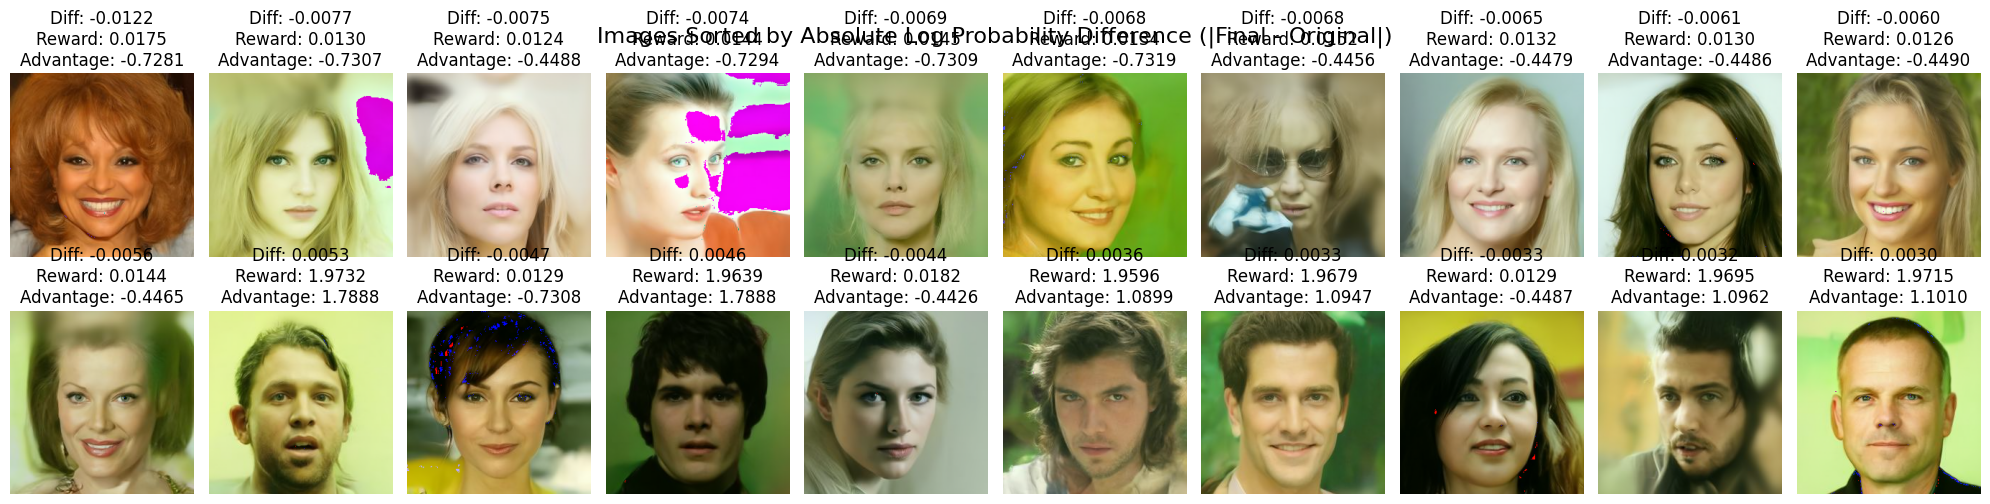

In [131]:
# Load images for each sample
sample_images = load_sample_images(samples, os.path.join("experiments", EXPERIMENT_NAME[:-4]))

# Get the last epoch data
last_epoch = samples['overall_epoch'].max()
last_epoch_samples = samples[samples['overall_epoch'] == last_epoch]

# Sort samples by absolute difference between old and new log probabilities
last_epoch_samples['log_prob_diff'] = last_epoch_samples['log_prob_new'] - last_epoch_samples['log_prob_old']
last_epoch_samples['abs_log_prob_diff'] = last_epoch_samples['log_prob_diff'].abs()
sorted_samples = last_epoch_samples.sort_values(by='abs_log_prob_diff', ascending=False)

# Display images sorted by absolute log probability difference (descending)
n_rows = len(sorted_samples) // 10
fig, axes = plt.subplots(n_rows, 10, figsize=(20, 5))
axes = axes.flatten()

for i, (_, row) in enumerate(sorted_samples.iterrows()):
    batch = row['batch']
    group = row['group']
    sample = row['sample']
    sex = row['sex']
    reward = row['reward']
    advantage = row['advantage']
    log_prob_old = row['log_prob_old']
    log_prob_new = row['log_prob_new']
    log_prob_diff = row['log_prob_diff']
    
    # Get the image
    img_key = (batch, group, sample)
    if img_key in sample_images:
        axes[i].imshow(np.array(sample_images[img_key]))
        axes[i].set_title(f"Diff: {log_prob_diff:.4f}\nReward: {reward:.4f}\nAdvantage: {advantage:.4f}", 
                         fontsize=12)
        axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, "Image not found", ha='center', va='center')
        axes[i].axis('off')

# Add a suptitle to the figure
fig.suptitle('Images Sorted by Absolute Log Probability Difference (|Final - Original|)', fontsize=16)

plt.tight_layout()
# Adjust layout to make room for the suptitle
plt.subplots_adjust(top=0.9)
plt.show()


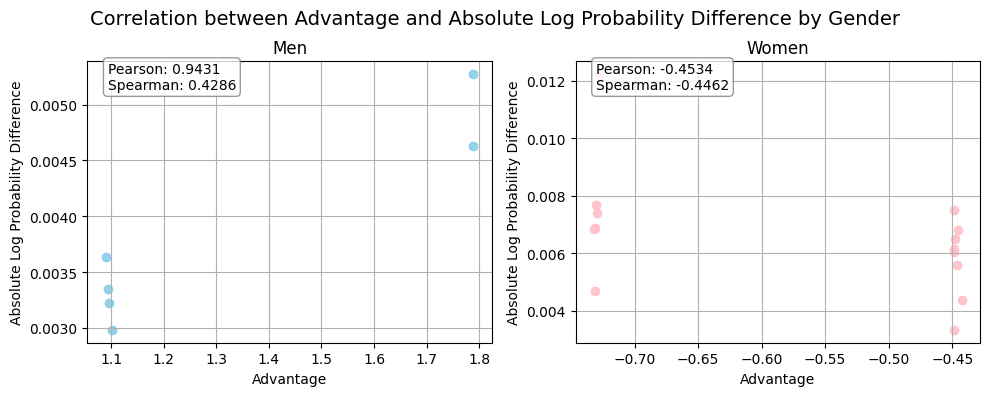

In [144]:
# Plot correlation between advantage and log probability difference separately for men and women
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Filter data for men and women
men_samples = last_epoch_samples[last_epoch_samples['sex'] == 'male']
women_samples = last_epoch_samples[last_epoch_samples['sex'] == 'female']

# Plot for men
axs[0].scatter(men_samples['advantage'], men_samples['abs_log_prob_diff'], alpha=0.9, color='skyblue')
axs[0].set_title('Men')
axs[0].set_xlabel('Advantage')
axs[0].set_ylabel('Absolute Log Probability Difference')
axs[0].grid(True)

# Calculate both Pearson and Spearman correlation coefficients for men
pearson_corr_men = men_samples['advantage'].corr(men_samples['abs_log_prob_diff'], method='pearson')
spearman_corr_men = men_samples['advantage'].corr(men_samples['abs_log_prob_diff'], method='spearman')

# Add correlation coefficients for men
axs[0].annotate(f'Pearson: {pearson_corr_men:.4f}\nSpearman: {spearman_corr_men:.4f}', 
             xy=(0.05, 0.9), 
             xycoords='axes fraction', 
             fontsize=10, 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Plot for women
axs[1].scatter(women_samples['advantage'], women_samples['abs_log_prob_diff'], alpha=0.9, color='pink')
axs[1].set_title('Women')
axs[1].set_xlabel('Advantage')
axs[1].set_ylabel('Absolute Log Probability Difference')
axs[1].grid(True)


# Calculate both Pearson and Spearman correlation coefficients for women
pearson_corr_women = women_samples['advantage'].corr(women_samples['abs_log_prob_diff'], method='pearson')
spearman_corr_women = women_samples['advantage'].corr(women_samples['abs_log_prob_diff'], method='spearman')

# Add correlation coefficients for women
axs[1].annotate(f'Pearson: {pearson_corr_women:.4f}\nSpearman: {spearman_corr_women:.4f}', 
             xy=(0.05, 0.9), 
             xycoords='axes fraction', 
             fontsize=10, 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Add a single suptitle
fig.suptitle('Correlation between Advantage and Absolute Log Probability Difference by Gender', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Make room for the suptitle
plt.show()


### 2.9 How does the average log-prob vary across epochs - overall and per sex?

### 2.10 How does the variance of the log-probs vary across epochs - overall and per sex?

### 2.11 Can I see the distribution of men and women shifting across the epochs?

### 2.12 How does the log-prob vary across the epochs for each individual step?

### 2.13 Can I see a different behaviors at different steps?

### 2.14 How is the difference between men and women at each step? Maybe plot men - women for each step

### 2.15 Do I see a pattern of increasing log-probs for women and decreasing log-prob for men?


# Old

In [ ]:
import matplotlib.pyplot as plt

num_cols = len(df.columns)
num_rows = (num_cols + 2) // 3
fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))
for i, column in enumerate(df.columns):
    if df[column].dtype == 'object':
        df[column].value_counts().plot(kind='bar', ax=axs[i//3, i%3], title=column, alpha=0.7, color='skyblue', edgecolor='black')
        axs[i//3, i%3].set_xlabel('Value')
        axs[i//3, i%3].set_ylabel('Frequency')
        axs[i//3, i%3].grid(True)
    else:
        df[column].plot(kind='hist', ax=axs[i//3, i%3], title=column, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        axs[i//3, i%3].set_xlabel('Value')
        axs[i//3, i%3].set_ylabel('Frequency')
        axs[i//3, i%3].grid(True)

## How do probabilities behave across steps?

In [ ]:
# Calculate the steps to display
steps = sorted(df["step"].unique())[::6]
num_steps = len(steps)

# Create a grid layout with appropriate dimensions
rows = (num_steps + 3) // 4  # 4 plots per row
cols = min(4, num_steps)

fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
axs = axs.flatten() if num_steps > 1 else [axs]

for i, step in enumerate(steps):
    step_data = df[df["step"] == step]
    
    # Split data by sex
    female_data = step_data[step_data["sex"] == "female"]["log_prob_new"]
    male_data = step_data[step_data["sex"] == "male"]["log_prob_new"]
    
    # Create boxplot with one box per sex
    box_data = [female_data, male_data]
    box_colors = ['pink', 'lightblue']
    
    bp = axs[i].boxplot(box_data, patch_artist=True, tick_labels=['female', 'male'])
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
    
    axs[i].set_title(f'Step {step}\nVariance: {step_data["log_prob_new"].var():.4f}')
    axs[i].set_ylabel('Log Prob New')
    axs[i].grid(True)

# Hide any unused subplots
for j in range(num_steps, len(axs)):
    axs[j].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))

# Get the variance data
step_variance = df.groupby(['step'])["log_prob_new"].var()

# Plot the original data points
plt.plot(step_variance, marker='o', linestyle='-', color='b', alpha=0.5, label='Original')

# Apply smoothing using a moving average
window_size = 5
smoothed_variance = step_variance.rolling(window=window_size, center=True).mean()

# Plot the smoothed curve
plt.plot(smoothed_variance, linewidth=1, color='r', label='Smoothed (Moving Avg)', linestyle="--")

plt.title('Variance of log_prob_new per step (with smoothed tendency)')
plt.xlabel('Step')
plt.ylabel('Variance')
plt.legend()
plt.grid(True)

In [ ]:
# Get the last step in the dataset
last_step = df['step'].min()

# Filter data for the last step and epoch 0
last_step_data = df[(df['step'] == last_step) & (df['epoch'] == 0)]

# Sort by log_prob_new in descending order
sorted_data = last_step_data.sort_values(by='log_prob_new', ascending=False)

sorted_data



In [ ]:
sorted_data["log_prob_new"].var()

The variance is higher between steps 30 and 40.

Just as a reminder: the log-prob refers to p(xt-1|xt)

A low variance of log-prob means that all the images have approximately the same likelihood of happening in that step.

A high variance of log-prob means that different images have considerably different likelihood of happening in that step.

>if i sample multiple trajectories and compute the log-prob of each image at each step, what should i expect from a curve of step vs variance of log-prob?

That's a great question about the statistical properties of log-probabilities across different sampling trajectories!

If you sample multiple trajectories and compute the log-probability at each timestep, the variance of these log-probabilities across trajectories would show a distinctive pattern:

1. **At t=T (start of sampling)**: 
   - Low variance between trajectories
   - Log-probabilities would be similar since all trajectories start from roughly the same pure noise distribution

2. **Middle timesteps (T/2)**:
   - Highest variance between trajectories
   - Different trajectories are exploring different modes of the distribution
   - The sampling process is in a phase where trajectories are maximally divergent

3. **Final timesteps (approaching t=0)**:
   - Decreasing variance
   - As trajectories converge toward their final images
   - The model's predictions become more certain

4. **At t=0**:
   - If included with a small epsilon: Extremely low variance between trajectories
   - The final denoising step is almost deterministic
   - Log-probabilities would be very similar (and very large) across all samples

So the expected curve of step vs. variance of log-prob would roughly follow an inverted U-shape: starting low, rising to a peak in the middle timesteps, then decreasing again toward the end.

This pattern emerges because:
- Early timesteps: All trajectories are operating on similar noise patterns
- Middle timesteps: Trajectories differentiate as they explore the probability space
- Late timesteps: Trajectories become more deterministic as they approach their final states

This variance analysis can actually provide insights into where your diffusion model is making its most critical decisions during the generation process!

> humm... interesting. this is what i'm seeing, but here's somehting i dont understand: the distributions p(xt-1|xt) have decreasing variance. so in the first timestpes, the variance would be large. but why when i sample various xt-1 from these early timesteps they have such similar likelihood?

That's a really insightful observation that gets at a key property of diffusion models!

You're right that there seems to be a paradox:
- The distributions p(x_{t-1}|x_t) have higher variance at early timesteps (t close to T)
- Yet when you sample different x_{t-1} from these distributions, they have similar log-likelihoods

This happens because of the relationship between distribution spread and information content:

1. **High noise levels (early timesteps):**
   - The distributions p(x_{t-1}|x_t) have high variance
   - BUT they're also very broad/flat distributions centered around similar means
   - In a broad Gaussian, points that are quite far apart can still have similar probability densities
   - The log-likelihood surface is relatively "flat" with gradual slopes

2. **Middle timesteps:**
   - The distributions become more structured and multimodal
   - Different trajectories start exploring genuinely different semantic regions
   - The log-likelihood surface develops "peaks" and "valleys"
   - Points from different trajectories are now in regions with very different likelihood values

3. **Low noise levels (late timesteps):**
   - The distributions have low variance but are highly structured
   - Small differences in position produce large differences in likelihood
   - However, the trajectories have largely converged to their final destinations

Think of it like this: In early timesteps, you're sampling from "almost pure noise" distributions where almost any sample is about as likely as any other. The distributions are wide but uniform-like in their central regions. As you progress through timesteps, the distributions become more structured and "opinionated" about which samples are high quality.

This is why your variance of log-probabilities follows an inverted U-shape even though the variance of the actual distributions p(x_{t-1}|x_t) decreases monotonically through the process.

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df.groupby(['step'])["log_prob_new"].mean(), marker='o', linestyle='-', color='b')
plt.title('Mean of log_prob_new per step')
plt.xlabel('Step')
plt.ylabel('Mean')
plt.grid(True)

The log probabilities increase across timesteps (as t decreases) because:

1. The variance of p(x_{t-1}|x_t) gets smaller as we approach t=0
2. Smaller variance means higher precision (1/variance)
3. Higher precision leads to more concentrated probability density
4. More concentrated density = higher peak probability values
5. The log of these higher probability values results in larger log probabilities

This is fundamentally because we're going from diffuse, high-entropy distributions (at large t) to concentrated, low-entropy distributions (at small t), which naturally have higher maximum probability densities.

In [ ]:
# Define steps to analyze (every n steps)
steps_to_analyze = sorted(df["step"].unique())[::6]
n_steps = len(steps_to_analyze)

# Create a figure with 2 columns (mean and variance) and rows for each step
fig, axs = plt.subplots(n_steps, 2, figsize=(12, 4*n_steps))

for i, step in enumerate(steps_to_analyze):
    step_by_epoch = df[df["step"]==step].groupby("overall_epoch")
    
    # Plot mean
    axs[i, 0].plot(step_by_epoch["log_prob_new"].mean(), marker='o', linestyle='-', color='b')
    axs[i, 0].set_title(f'Mean of log_prob_new per epoch in step {step}')
    axs[i, 0].set_ylabel('Mean')
    
    # Show fewer x-ticks to avoid crowding
    min_epoch = min(step_by_epoch.groups.keys())
    max_epoch = max(step_by_epoch.groups.keys())
    tick_interval = max(1, (max_epoch - min_epoch) // 5)  # Show at most ~5 ticks
    axs[i, 0].set_xticks(range(min_epoch, max_epoch + 1, tick_interval))
    
    # Plot variance
    axs[i, 1].plot(step_by_epoch["log_prob_new"].var(), marker='o', linestyle='-', color='b')
    axs[i, 1].set_title(f'Variance of log_prob_new per epoch in step {step}')
    axs[i, 1].set_ylabel('Variance')
    
    # Use the same tick interval for the second plot
    axs[i, 1].set_xticks(range(min_epoch, max_epoch + 1, tick_interval))
    
    # Add grid and labels
    for ax in axs[i]:
        ax.grid(True)
        ax.set_xlabel('Epoch')  # Add x-label for clarity

plt.tight_layout()
plt.show()

## What is the contribution of each step?

How are the male and female likelihoods different from each other in the original model?

In [ ]:
per_sample_prob = df.groupby(['overall_epoch', 'batch', 'group', 'sample']).sum()
per_sample_prob.reset_index(inplace=True)

# Filter for a specific epoch (using 0 as an example)
epoch_data = per_sample_prob[per_sample_prob["overall_epoch"]==0]

# Define colors based on gender
colors = ['pink' if "female" in sex else 'blue' for sex in epoch_data["sex"]]

# Create bar plot with adjusted y-axis to better show differences
plt.figure(figsize=(10, 6))

# Sort data to better visualize patterns
sorted_indices = epoch_data['log_prob_old'].argsort()
sorted_data = epoch_data.iloc[sorted_indices]
sorted_colors = [colors[i] for i in sorted_indices]

# Calculate min and max for better y-axis limits
min_val = sorted_data['log_prob_old'].min()
max_val = sorted_data['log_prob_old'].max()
y_margin = (max_val - min_val) * 0.1  # 10% margin

plt.bar(range(len(sorted_data)), 
        sorted_data['log_prob_old'], 
        color=sorted_colors,
        alpha=0.7,
        edgecolor='black',
        linewidth=0.5)

# Set y-axis limits to zoom in on the differences
plt.ylim(min_val - y_margin, max_val + y_margin)

# Add titles and labels
plt.title('Distribution of log_prob_old Across Samples')
plt.xlabel('Sample Index (sorted by log_prob_old)')
plt.ylabel('Log Prob Old')

# Add legend for gender colors
import matplotlib.patches as mpatches
pink_patch = mpatches.Patch(color='pink', label='Female')
blue_patch = mpatches.Patch(color='blue', label='Male')
plt.legend(handles=[pink_patch, blue_patch])

# Show plot with more prominent grid for easier comparison
plt.grid(True, alpha=0.5, axis='y', linestyle='--')
plt.show()

It seems messy. Maybe I can check if the probabilities are better differentiated in specific steps

In [ ]:
# Define step interval for plotting
step_interval = 3  # Plot every 5 steps

# Get unique steps in the data
unique_steps = sorted(df["step"].unique())

# Select steps at regular intervals
steps_to_plot = unique_steps[::step_interval]

# Calculate number of rows and columns for the grid
n_plots = len(steps_to_plot)
n_cols = 4  # Number of columns in the grid (changed from 2 to 4)
n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division to get number of rows

# Create a figure with a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 2.5 * n_rows))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Create plots for each selected step
for i, step in enumerate(steps_to_plot):
    # Filter data for the current step and epoch 0
    step_data = df[(df["step"] == step) & (df["overall_epoch"] == 0)]
    
    # Group by sample to get per-sample data at this specific step
    # Convert object columns to appropriate types before aggregation
    numeric_cols = ['log_prob_old', 'log_prob_new']
    per_sample_step = step_data.groupby(['batch', 'group', 'sample']).agg(
        {col: 'mean' for col in numeric_cols}
    ).reset_index()
    
    # Merge back non-numeric columns we need (like sex)
    # Get one row per sample to avoid duplicates
    sample_info = step_data.groupby(['batch', 'group', 'sample']).first()[['sex']].reset_index()
    per_sample_step = pd.merge(per_sample_step, sample_info, on=['batch', 'group', 'sample'])
    
    # Define colors based on gender
    colors = ['pink' if "female" in sex else 'blue' for sex in per_sample_step["sex"]]
    
    # Get the current axis
    ax = axes[i]
    
    # Sort data to better visualize patterns
    sorted_indices = per_sample_step['log_prob_old'].argsort()
    sorted_data = per_sample_step.iloc[sorted_indices]
    sorted_colors = [colors[i] for i in sorted_indices]
    
    # Calculate min and max for better y-axis limits
    min_val = sorted_data['log_prob_old'].min()
    max_val = sorted_data['log_prob_old'].max()
    y_margin = (max_val - min_val) * 0.1  # 10% margin
    
    ax.bar(range(len(sorted_data)), 
           sorted_data['log_prob_old'], 
           color=sorted_colors,
           alpha=0.7,
           edgecolor='black',
           linewidth=0.5)
    
    # Set y-axis limits to zoom in on the differences
    ax.set_ylim(min_val - y_margin, max_val + y_margin)
    
    # Add titles and labels with smaller font size
    ax.set_title(f'Step {step}', fontsize=9)
    ax.set_xlabel('Sample Index', fontsize=8)
    ax.set_ylabel('Log Prob Old', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=7)
    
    # Add grid for easier comparison
    ax.grid(True, alpha=0.5, axis='y', linestyle='--')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Add a common legend for the entire figure
import matplotlib.patches as mpatches
pink_patch = mpatches.Patch(color='pink', label='Female')
blue_patch = mpatches.Patch(color='blue', label='Male')
fig.legend(handles=[pink_patch, blue_patch], loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=2)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Make room for the legend
plt.show()

Okay... Maybe they weren't supposed to be separate. In the end, they are sampled from the same distribution, it's reasonable to think that all images have high likelihoods, otherwise they wouldn't be sampled.

I could only explore this if I somehow managed to get trajectories without actually sampling. Then I would probably see that, overall, women samples have higher likelihoods.

In [ ]:
from scipy.signal import find_peaks

# Get unique steps in the data
unique_steps = sorted(df["step"].unique())

# Select steps at regular intervals
steps_to_plot = unique_steps[::step_interval]

for step in steps_to_plot:
    step_data = df[df["step"] == step]
    
    # Calculate averages for male and female
    female_data = step_data[step_data["sex"].str.contains("female")]
    male_data = step_data[~step_data["sex"].str.contains("female")]
    
    # Create figure with three subplots side by side
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
    
    
    # First subplot - Scatter plot with all data
    ax1.scatter(female_data["overall_epoch"], 
               female_data["log_prob_new"], 
               c='pink', 
               s=50, 
               alpha=0.7, 
               edgecolors='w', 
               linewidth=0.5,
               label='Female')
    
    ax1.scatter(male_data["overall_epoch"], 
               male_data["log_prob_new"], 
               c='blue', 
               s=50, 
               alpha=0.7, 
               edgecolors='w', 
               linewidth=0.5,
               label='Male')
    
    # Add titles and labels
    ax1.set_title(f'Log Prob New vs. Epochs (Step {step})')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Log Prob New')
    ax1.legend()
    ax1.grid(True)
    
    # Second subplot - Female averages only
    if not female_data.empty:
        # Group by epoch and calculate mean
        female_avg = female_data.groupby("overall_epoch")["log_prob_new"].mean()
        ax2.plot(female_avg.index, female_avg.values, 'pink', linestyle='-', linewidth=2, label='Female Avg')

        # Find peaks
        peaks, _ = find_peaks(female_avg.values, distance=1)  # Adjust distance as needed
        peak_x = [female_avg.index[i] for i in peaks]
        peak_y = [female_avg.values[i] for i in peaks]
        ax2.plot(peak_x, peak_y, c='black', linewidth=0.8, linestyle='--', marker='o', markersize=2, alpha=0.7, label='Peaks')

    # Add titles and labels
    ax2.set_title(f'Female Average Log Prob New (Step {step})')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Average Log Prob New')
    ax2.legend()
    ax2.grid(True)
    
    # Third subplot - Male averages only
    if not male_data.empty:
        # Group by epoch and calculate mean
        male_avg = male_data.groupby("overall_epoch")["log_prob_new"].mean()
        ax3.plot(male_avg.index, male_avg.values, 'blue', linestyle='-', linewidth=2, label='Male Avg')
    
        minima, _ = find_peaks(male_avg.values, distance=1)  # Adjust distance as needed
        min_x = [male_avg.index[i] for i in minima]
        min_y = [male_avg.values[i] for i in minima]
        ax3.plot(min_x, min_y, c='black', linewidth=0.8, linestyle='--', marker='o', markersize=3, alpha=0.7, label='Minima')


    # Add titles and labels
    ax3.set_title(f'Male Average Log Prob New (Step {step})')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Average Log Prob New')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

Some conclusions:
1. It's not obvio

In [ ]:
df["batch"].value_counts()

In [ ]:
!pip install scipy

Let's check the original probabilities for each sampling epoch

In [ ]:
from scipy.signal import find_peaks

# Get unique sampling epochs
sampling_epochs = df["sampling_epoch"].unique()

# Get steps to keep
steps = sorted(df["step"].unique())  
steps_to_keep = steps[20:40] 

# Create one plot per sampling epoch
for sampling_epoch in sampling_epochs:
    # Filter data for the current sampling epoch
    df_sampling = df[(df["sampling_epoch"] == sampling_epoch)]
    
    # Group by step and gender to calculate averages
    # Convert to numeric first to avoid TypeError with object dtype
    female_df = df_sampling[df_sampling["sex"] == "female"].copy()
    male_df = df_sampling[df_sampling["sex"] == "male"].copy()
    
    # Ensure log_prob_old is numeric
    female_df["log_prob_new"] = pd.to_numeric(female_df["log_prob_new"], errors='coerce')
    male_df["log_prob_new"] = pd.to_numeric(male_df["log_prob_new"], errors='coerce')
    
    # Now calculate means
    female_avg = female_df.groupby("step")["log_prob_new"].mean()
    male_avg = male_df.groupby("step")["log_prob_new"].mean()
    
    # Filter the averages to include only the selected steps
    female_avg_filtered = female_avg.loc[female_avg.index.intersection(steps_to_keep)]
    male_avg_filtered = male_avg.loc[male_avg.index.intersection(steps_to_keep)]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    if not female_avg_filtered.empty:                
        plt.plot(female_avg_filtered.index, female_avg_filtered.values, 'pink', linestyle='-', linewidth=2, label='Female Avg')

    if not male_avg_filtered.empty:
        plt.plot(male_avg_filtered.index, male_avg_filtered.values, 'blue', linestyle='-', linewidth=2, label='Male Avg')
    
    # Add titles and labels
    plt.title(f'Average Log Prob Old vs. Step (Sampling Epoch {sampling_epoch}, Steps 20-40)')
    plt.xlabel('Step')
    plt.ylabel('Average Log Prob Old')
    plt.legend()
    plt.grid(True)
    plt.show()


## Loss components

In [ ]:
import matplotlib.pyplot as plt

# Calculate the summed loss_clip for each sample
sample_loss_sums = df.groupby(['sampling_epoch', 'batch', 'group', 'sample'])['loss_clip'].sum().reset_index()

# Create a bar plot for the summed loss_clip for each sample
plt.figure(figsize=(10, 6))
colors = ['pink' if loss < 0 else 'blue' for loss in sample_loss_sums['loss_clip']]
plt.bar(range(len(sample_loss_sums)), sample_loss_sums['loss_clip'], color=colors)

# Add labels and title
plt.title('Summed Loss Clip for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('Summed Loss Clip')
plt.grid(True, axis='y')

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Calculate and plot the average of the samples in pink and blue considering the computed epochs
per_sample_stats['computed_epoch'] = per_sample_stats['sampling_epoch'] * 3 + per_sample_stats['epoch'] + per_sample_stats['sampling_epoch']

avg_pink = per_sample_stats[per_sample_stats['loss_clip'] < 0].groupby('computed_epoch')['log_prob_new'].mean()
avg_pink_old = per_sample_stats[per_sample_stats['loss_clip'] < 0].groupby('computed_epoch')['log_prob_old'].mean()
avg_blue = per_sample_stats[per_sample_stats['loss_clip'] >= 0].groupby('computed_epoch')['log_prob_new'].mean()
avg_blue_old = per_sample_stats[per_sample_stats['loss_clip'] >= 0].groupby('computed_epoch')['log_prob_old'].mean()
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot for pink samples
axs[0].plot(avg_pink.index, avg_pink.values, marker='o', color='pink', label='Training model')
axs[0].plot(avg_pink.index, avg_pink_old.values, linestyle='--', label='Reference model', color='pink')
axs[0].set_title('Average Log Prob New over Computed Epochs (Women Samples)')
axs[0].set_xlabel('Computed Epochs')
axs[0].set_ylabel('Average Log Prob New')
axs[0].legend()
axs[0].grid(True)

# Plot for blue samples
axs[1].plot(avg_blue.index, avg_blue.values, marker='o', color='blue', label='Training model')
axs[1].plot(avg_pink.index, avg_blue_old.values, linestyle='--', label='Reference model', color='blue')
axs[1].set_title('Average Log Prob New over Computed Epochs (Men Samples)')
axs[1].set_xlabel('Computed Epochs')
axs[1].set_ylabel('Average Log Prob New')
axs[1].legend()
axs[1].grid(True)

# Plot both pink and blue samples together
axs[2].plot(avg_pink.index, avg_pink.values, marker='o', color='pink', label='Average of Women Samples')
axs[2].plot(avg_blue.index, avg_blue.values, marker='o', color='blue', label='Average of Men Samples')
axs[2].set_title('Average Log Prob New over Computed Epochs (Women and Men Samples)')
axs[2].set_xlabel('Computed Epochs')
axs[2].set_ylabel('Average Log Prob New')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Create a line plot for each sample within each sampling epoch, epoch, and batch showing the evolution of loss_clip over computed epochs
grouped = per_sample_stats.groupby(['sampling_epoch', 'batch', 'group', 'sample'])
for (sampling_epoch, batch, group, sample), sample_data in grouped:
    plt.figure(figsize=(10, 6))
    color = 'pink' if sample_data['loss_clip'].iloc[0] < 0 else 'blue'
    plt.plot(sample_data["epoch"], sample_data['loss_clip'], marker='o', color=color, label=f'Sampling epoch {sampling_epoch}, Batch {batch}, Group {group}, Sample {sample}')
    plt.title(f'Evolution of Loss Clip over Computed Epochs')
    plt.xlabel('Computed Epochs')
    plt.ylabel('Loss Clip')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# Create a subplot for each sample showing the evolution of importance_ratio over steps
import matplotlib.pyplot as plt

# Determine the number of subplots needed
num_samples = len(df.groupby(['sampling_epoch', 'batch', 'group', 'sample']))

fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Iterate through each group and corresponding subplot
for ax, ((sampling_epoch, batch, group, sample), sample_data) in zip(axes, df.groupby(['sampling_epoch', 'batch', 'group', 'sample'])):
    gender = 'Man' if sample_data['loss_clip'].sum() > 0 else 'Woman'
    for epoch, epoch_data in sample_data.groupby('epoch'):
        ax.plot(epoch_data['step'], epoch_data['importance_ratio'], marker='o', label=f'Epoch {epoch}')
    ax.axhline(y=1-1e-4, color='gray', linestyle='--', linewidth=1, label='Lower Clip (1-1e-4)')
    ax.axhline(y=1+1e-4, color='gray', linestyle='--', linewidth=1, label='Upper Clip (1+1e-4)')
    ax.set_title(f'Sample {sample} / Batch {batch} ({gender})')
    ax.set_xlabel('Steps')
    ax.set_ylabel('Importance Ratio')
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for ax in axes[num_samples:]:
    ax.set_visible(False)
plt.suptitle('Evolution of Importance Ratio over Timesteps')
plt.tight_layout()
plt.show()

In [ ]:
df["log_prob_new"]

In [ ]:
# i want to see the gradient aggregated by sex over the epochs. but the gradient is saved to df accumulated. also it would be interesting to see percentage of clipping. like, for a given epoch, what percentage of the steps
# why the last step has that high probabilty which is the same for all images?
# aggregate gradient (without accumulation) by step,sex, one line per epoch

In [ ]:
# Create a subplot for each sample showing the evolution of log_prob_new over steps
import matplotlib.pyplot as plt

# Determine the number of subplots needed
num_samples = len(df.groupby(['sampling_epoch', 'batch', 'group', 'sample']))

fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)


# Flatten axes array for easy iteration
axes = axes.flatten()

# Iterate through each group and corresponding subplot
for ax, ((sampling_epoch, batch, group, sample), sample_data) in zip(axes, df.groupby(['sampling_epoch', 'batch', 'group', 'sample'])):
    gender = 'Man' if sample_data['loss_clip'].sum() > 0 else 'Woman'
    for epoch, epoch_data in sample_data.groupby('epoch'):
        ax.plot(epoch_data['step'][:-4], epoch_data['log_prob_new'][:-4], marker='o', label=f'Epoch {epoch}')
    ax.axhline(y=1-1e-4, color='gray', linestyle='--', linewidth=1, label='Lower Clip (1-1e-4)')
    ax.axhline(y=1+1e-4, color='gray', linestyle='--', linewidth=1, label='Upper Clip (1+1e-4)')
    ax.set_title(f'Sample {sample} / Batch {batch} ({gender})')
    ax.set_xlabel('Steps')
    ax.set_ylabel('Log Probability New')
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for ax in axes[num_samples:]:
    ax.set_visible(False)
plt.suptitle('Evolution of Log Probability New over Timesteps')
plt.tight_layout()
plt.show()

In [ ]:
# Create a subplot for each sample showing the evolution of gradient over steps
import matplotlib.pyplot as plt

# Determine the number of subplots needed
num_samples = len(df.groupby(['sampling_epoch', 'batch', 'group', 'sample']))

fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Iterate through each group and corresponding subplot
for ax, ((sampling_epoch, batch, group, sample), sample_data) in zip(axes, df.groupby(['sampling_epoch', 'batch', 'group', 'sample'])):
    gender = 'Man' if sample_data['loss_clip'].sum() > 0 else 'Woman'
    for epoch, epoch_data in sample_data.groupby('epoch'):
        ax.plot(epoch_data['step'], epoch_data['gradient_per_step'], marker='o', label=f'Epoch {epoch}')
    ax.axhline(y=1-1e-4, color='gray', linestyle='--', linewidth=1, label='Lower Clip (1-1e-4)')
    ax.axhline(y=1+1e-4, color='gray', linestyle='--', linewidth=1, label='Upper Clip (1+1e-4)')
    ax.set_title(f'Sample {sample} / Batch {batch} ({gender})')
    ax.set_xlabel('Steps')
    ax.set_ylabel('Gradient')
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for ax in axes[num_samples:]:
    ax.set_visible(False)
plt.suptitle('Evolution of Gradient over Timesteps')
plt.tight_layout()
plt.show()

In [ ]:
# Create a subplot for each sample showing the evolution of importance_ratio over steps
import matplotlib.pyplot as plt

# Determine the number of subplots needed
num_samples = len(df.groupby(['sampling_epoch', 'batch', 'group', 'sample']))

fig, axes = plt.subplots(2, 5, figsize=(30, 10), sharex=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Iterate through each group and corresponding subplot
for ax, ((sampling_epoch, batch, group, sample), sample_data) in zip(axes, df.groupby(['sampling_epoch', 'batch', 'group', 'sample'])):
    gender = 'Man' if sample_data['loss_clip'].sum() > 0 else 'Woman'
    for epoch, epoch_data in sample_data.groupby('epoch'):
        ax.plot(epoch_data['step'], epoch_data['loss_clip'], marker='o', label=f'Epoch {epoch}')
    ax.set_title(f'Sample {sample} / Batch {batch} ({gender})')
    ax.set_xlabel('Steps')
    ax.set_ylabel('Loss clip')
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for ax in axes[num_samples:]:
    ax.set_visible(False)
plt.suptitle('Evolution of Loss clip over Timesteps')
plt.tight_layout()
plt.show()

In [ ]:
per_sample_stats

In [ ]:
import matplotlib.pyplot as plt

# Create a line plot for each sample within each sampling epoch, epoch, and batch showing the evolution of log_prob_new over computed epochs
grouped = per_sample_stats.groupby(['sampling_epoch', 'batch', 'group', 'sample'])
for (sampling_epoch, batch, group, sample), sample_data in grouped:
    plt.figure(figsize=(10, 6))
    color = 'pink' if sample_data['loss_clip'].iloc[0] < 0 else 'blue'
    plt.plot(sample_data["epoch"], sample_data['kl_loss'], marker='o', color=color, label=f'Sampling epoch {sampling_epoch}, Batch {batch}, Group {group}, Sample {sample}')
    plt.title(f'Evolution of KL loss over Computed Epochs')
    plt.xlabel('Computed Epochs')
    plt.ylabel('KL loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# Calculate and plot the average KL loss of the samples in pink and blue considering the computed epochs
per_sample_stats['computed_epoch'] = per_sample_stats['sampling_epoch'] * 3 + per_sample_stats['epoch'] + per_sample_stats['sampling_epoch']

avg_pink_kl = per_sample_stats[per_sample_stats['loss_clip'] < 0].groupby('computed_epoch')['kl_loss'].mean()
avg_blue_kl = per_sample_stats[per_sample_stats['loss_clip'] >= 0].groupby('computed_epoch')['kl_loss'].mean()

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot for pink samples
axs[0].plot(avg_pink_kl.index, avg_pink_kl.values, marker='o', color='pink', label='Training model')
axs[0].set_title('Average KL Loss over Computed Epochs (Women Samples)')
axs[0].set_xlabel('Computed Epochs')
axs[0].set_ylabel('Average KL Loss')
axs[0].legend()
axs[0].grid(True)

# Plot for blue samples
axs[1].plot(avg_blue_kl.index, avg_blue_kl.values, marker='o', color='blue', label='Training model')
axs[1].set_title('Average KL Loss over Computed Epochs (Men Samples)')
axs[1].set_xlabel('Computed Epochs')
axs[1].set_ylabel('Average KL Loss')
axs[1].legend()
axs[1].grid(True)

# Plot both pink and blue samples together
axs[2].plot(avg_pink_kl.index, avg_pink_kl.values, marker='o', color='pink', label='Average of Women Samples')
axs[2].plot(avg_blue_kl.index, avg_blue_kl.values, marker='o', color='blue', label='Average of Men Samples')
axs[2].set_title('Average KL Loss over Computed Epochs (Women and Men Samples)')
axs[2].set_xlabel('Computed Epochs')
axs[2].set_ylabel('Average KL Loss')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Calculate and plot the average gradient per step of the samples in pink and blue considering the computed epochs
per_sample_stats['computed_epoch'] = per_sample_stats['sampling_epoch'] * 3 + per_sample_stats['epoch'] + per_sample_stats['sampling_epoch']

avg_pink_grad = per_sample_stats[per_sample_stats['loss_clip'] < 0].groupby('computed_epoch')['gradient_per_step'].mean()
avg_blue_grad = per_sample_stats[per_sample_stats['loss_clip'] >= 0].groupby('computed_epoch')['gradient_per_step'].mean()

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot for pink samples
axs[0].plot(avg_pink_grad.index, avg_pink_grad.values, marker='o', color='pink', label='Training model')
axs[0].set_title('Average Gradient per Step over Computed Epochs (Women Samples)')
axs[0].set_xlabel('Computed Epochs')
axs[0].set_ylabel('Average Gradient per Step')
axs[0].legend()
axs[0].grid(True)

# Plot for blue samples
axs[1].plot(avg_blue_grad.index, avg_blue_grad.values, marker='o', color='blue', label='Training model')
axs[1].set_title('Average Gradient per Step over Computed Epochs (Men Samples)')
axs[1].set_xlabel('Computed Epochs')
axs[1].set_ylabel('Average Gradient per Step')
axs[1].legend()
axs[1].grid(True)

# Plot both pink and blue samples together
axs[2].plot(avg_pink_grad.index, avg_pink_grad.values, marker='o', color='pink', label='Average of Women Samples')
axs[2].plot(avg_blue_grad.index, avg_blue_grad.values, marker='o', color='blue', label='Average of Men Samples')
axs[2].set_title('Average Gradient per Step over Computed Epochs (Women and Men Samples)')
axs[2].set_xlabel('Computed Epochs')
axs[2].set_ylabel('Average Gradient per Step')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Calculate and plot the average KL loss of the samples in pink and blue considering the computed epochs
per_sample_stats['computed_epoch'] = per_sample_stats['sampling_epoch'] * 3 + per_sample_stats['epoch'] + per_sample_stats['sampling_epoch']

avg_pink_kl = per_sample_stats[per_sample_stats['loss_clip'] < 0].groupby('computed_epoch')['kl_loss'].mean()
avg_blue_kl = per_sample_stats[per_sample_stats['loss_clip'] >= 0].groupby('computed_epoch')['kl_loss'].mean()

avg_pink_loss_base = per_sample_stats[per_sample_stats['loss_clip'] < 0].groupby('computed_epoch')['loss_base'].mean()
avg_blue_loss_base = per_sample_stats[per_sample_stats['loss_clip'] >= 0].groupby('computed_epoch')['loss_base'].mean()

# Normalize the data
avg_pink_kl = (avg_pink_kl - avg_pink_kl.mean()) / avg_pink_kl.std()
avg_blue_kl = (avg_blue_kl - avg_blue_kl.mean()) / avg_blue_kl.std()
avg_pink_loss_base = (avg_pink_loss_base - avg_pink_loss_base.mean()) / avg_pink_loss_base.std()
avg_blue_loss_base = (avg_blue_loss_base - avg_blue_loss_base.mean()) / avg_blue_loss_base.std()

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot for pink samples
axs[0].plot(avg_pink_kl.index, avg_pink_kl.values, marker='o', color='pink', label='KL Loss (Women)')
axs[0].plot(avg_pink_loss_base.index, avg_pink_loss_base.values, marker='x', linestyle='--', color='pink', label='Loss Base (Women)')
axs[0].set_title('Average KL Loss over Computed Epochs (Women Samples)')
axs[0].set_xlabel('Computed Epochs')
axs[0].set_ylabel('Average KL Loss')
axs[0].legend()
axs[0].grid(True)

# Plot for blue samples
axs[1].plot(avg_blue_kl.index, avg_blue_kl.values, marker='o', color='blue', label='KL Loss (Men)')
axs[1].plot(avg_blue_loss_base.index, avg_blue_loss_base.values, marker='x', linestyle='--', color='blue', label='Loss Base (Men)')
axs[1].set_title('Average KL Loss over Computed Epochs (Men Samples)')
axs[1].set_xlabel('Computed Epochs')
axs[1].set_ylabel('Average KL Loss')
axs[1].legend()
axs[1].grid(True)

# Plot both pink and blue samples together
axs[2].plot(avg_pink_kl.index, avg_pink_kl.values, marker='o', color='pink', label='KL Loss (Women)')
axs[2].plot(avg_blue_kl.index, avg_blue_kl.values, marker='o', color='blue', label='KL Loss (Men)')
axs[2].plot(avg_pink_loss_base.index, avg_pink_loss_base.values, marker='x', linestyle='--', color='pink', label='Loss Base (Women)')
axs[2].plot(avg_blue_loss_base.index, avg_blue_loss_base.values, marker='x', linestyle='--', color='blue', label='Loss Base (Men)')
axs[2].set_title('Average KL Loss over Computed Epochs (Women and Men Samples)')
axs[2].set_xlabel('Computed Epochs')
axs[2].set_ylabel('Average KL Loss')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Calculate and plot the average importance ratio of the samples in pink and blue considering the computed epochs
per_sample_stats['computed_epoch'] = per_sample_stats['sampling_epoch'] * 3 + per_sample_stats['epoch'] + per_sample_stats['sampling_epoch']

avg_pink_importance_ratio = per_sample_stats[per_sample_stats['loss_clip'] < 0].groupby('computed_epoch')['importance_ratio'].mean()
avg_blue_importance_ratio = per_sample_stats[per_sample_stats['loss_clip'] >= 0].groupby('computed_epoch')['importance_ratio'].mean()

avg_pink_clipped_ratio = per_sample_stats[per_sample_stats['loss_clip'] < 0].groupby('computed_epoch')['clipped_ratio'].mean()
avg_blue_clipped_ratio = per_sample_stats[per_sample_stats['loss_clip'] >= 0].groupby('computed_epoch')['clipped_ratio'].mean()

# Define min and max lines
min_line = 50 * (1 - 1e-4)
max_line = 50 * (1 + 1e-4)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(22, 5))

# Plot for pink samples
axs[0].plot(avg_pink_importance_ratio.index, avg_pink_importance_ratio.values, marker='o', color='pink', label='Importance Ratio (Women)')
axs[0].plot(avg_pink_clipped_ratio.index, avg_pink_clipped_ratio.values, marker='x', linestyle='--', color='pink', label='Clipped Ratio (Women)')
axs[0].axhline(y=min_line, color='grey', linestyle='--', label='Min Line')
axs[0].axhline(y=max_line, color='grey', linestyle='--', label='Max Line')
axs[0].set_title('Average Importance Ratio over Computed Epochs (Women Samples)')
axs[0].set_xlabel('Computed Epochs')
axs[0].set_ylabel('Average Importance Ratio')
axs[0].legend()
axs[0].grid(True)

# Plot for blue samples
axs[1].plot(avg_blue_importance_ratio.index, avg_blue_importance_ratio.values, marker='o', color='blue', label='Importance Ratio (Men)')
axs[1].plot(avg_blue_clipped_ratio.index, avg_blue_clipped_ratio.values, marker='x', linestyle='--', color='blue', label='Clipped Ratio (Men)')
axs[1].axhline(y=min_line, color='grey', linestyle='--', label='Min Line')
axs[1].axhline(y=max_line, color='grey', linestyle='--', label='Max Line')
axs[1].set_title('Average Importance Ratio over Computed Epochs (Men Samples)')
axs[1].set_xlabel('Computed Epochs')
axs[1].set_ylabel('Average Importance Ratio')
axs[1].legend()
axs[1].grid(True)

# Plot both pink and blue samples together
axs[2].plot(avg_pink_importance_ratio.index, avg_pink_importance_ratio.values, marker='o', color='pink', label='Importance Ratio (Women)')
axs[2].plot(avg_blue_importance_ratio.index, avg_blue_importance_ratio.values, marker='o', color='blue', label='Importance Ratio (Men)')
axs[2].plot(avg_pink_clipped_ratio.index, avg_pink_clipped_ratio.values, marker='x', linestyle='--', color='pink', label='Clipped Ratio (Women)')
axs[2].plot(avg_blue_clipped_ratio.index, avg_blue_clipped_ratio.values, marker='x', linestyle='--', color='blue', label='Clipped Ratio (Men)')
axs[2].axhline(y=min_line, color='grey', linestyle='--', label='Min Line')
axs[2].axhline(y=max_line, color='grey', linestyle='--', label='Max Line')
axs[2].set_title('Average Importance Ratio over Computed Epochs (Women and Men Samples)')
axs[2].set_xlabel('Computed Epochs')
axs[2].set_ylabel('Average Importance Ratio')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Calculate and plot the average of the samples in pink and blue considering the computed epochs
per_sample_stats['computed_epoch'] = per_sample_stats['sampling_epoch'] * 3 + per_sample_stats['epoch'] + per_sample_stats['sampling_epoch']

avg_pink = per_sample_stats[per_sample_stats['loss_clip'] < 0].groupby('computed_epoch')['clipped_ratio'].mean()
avg_blue = per_sample_stats[per_sample_stats['loss_clip'] >= 0].groupby('computed_epoch')['clipped_ratio'].mean()
avg_overall = per_sample_stats.groupby('computed_epoch')['clipped_ratio'].mean()

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Plot for pink samples
axs[0, 0].plot(avg_pink.index, avg_pink.values, marker='o', color='pink', label='Training model')
axs[0, 0].set_title('Average Clipped Ratio over Computed Epochs (Women Samples)')
axs[0, 0].set_xlabel('Computed Epochs')
axs[0, 0].set_ylabel('Average Clipped Ratio')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot for blue samples
axs[0, 1].plot(avg_blue.index, avg_blue.values, marker='o', color='blue', label='Training model')
axs[0, 1].set_title('Average Clipped Ratio over Computed Epochs (Men Samples)')
axs[0, 1].set_xlabel('Computed Epochs')
axs[0, 1].set_ylabel('Average Clipped Ratio')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot both pink and blue samples together
axs[1, 0].plot(avg_pink.index, avg_pink.values, marker='o', color='pink', label='Average of Women Samples')
axs[1, 0].plot(avg_blue.index, avg_blue.values, marker='o', color='blue', label='Average of Men Samples')
axs[1, 0].set_title('Average Clipped Ratio over Computed Epochs (Women and Men Samples)')
axs[1, 0].set_xlabel('Computed Epochs')
axs[1, 0].set_ylabel('Average Clipped Ratio')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot for overall average
axs[1, 1].plot(avg_overall.index, avg_overall.values, marker='o', color='green', label='Overall Average')
axs[1, 1].set_title('Overall Average Clipped Ratio over Computed Epochs')
axs[1, 1].set_xlabel('Computed Epochs')
axs[1, 1].set_ylabel('Overall Average Clipped Ratio')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Calculate and plot the average of the samples in pink and blue considering the computed epochs
per_sample_stats['computed_epoch'] = per_sample_stats['sampling_epoch'] * 3 + per_sample_stats['epoch'] + per_sample_stats['sampling_epoch']

avg_pink = per_sample_stats[per_sample_stats['loss_clip'] < 0].groupby('computed_epoch')['clipped_ratio'].mean()
avg_blue = per_sample_stats[per_sample_stats['loss_clip'] >= 0].groupby('computed_epoch')['clipped_ratio'].mean()
avg_overall = per_sample_stats.groupby('computed_epoch')['clipped_ratio'].mean()

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Plot for pink samples
axs[0, 0].plot(avg_pink.index, avg_pink.values, marker='o', color='pink', label='Training model')
axs[0, 0].set_title('Average Clipped Ratio over Computed Epochs (Women Samples)')
axs[0, 0].set_xlabel('Computed Epochs')
axs[0, 0].set_ylabel('Average Clipped Ratio')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot for blue samples
axs[0, 1].plot(avg_blue.index, avg_blue.values, marker='o', color='blue', label='Training model')
axs[0, 1].set_title('Average Clipped Ratio over Computed Epochs (Men Samples)')
axs[0, 1].set_xlabel('Computed Epochs')
axs[0, 1].set_ylabel('Average Clipped Ratio')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot both pink and blue samples together
axs[1, 0].plot(avg_pink.index, avg_pink.values, marker='o', color='pink', label='Average of Women Samples')
axs[1, 0].plot(avg_blue.index, avg_blue.values, marker='o', color='blue', label='Average of Men Samples')
axs[1, 0].set_title('Average Clipped Ratio over Computed Epochs (Women and Men Samples)')
axs[1, 0].set_xlabel('Computed Epochs')
axs[1, 0].set_ylabel('Average Clipped Ratio')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot for overall average
axs[1, 1].plot(avg_overall.index, avg_overall.values, marker='o', color='green', label='Overall Average')
axs[1, 1].set_title('Overall Average Clipped Ratio over Computed Epochs')
axs[1, 1].set_xlabel('Computed Epochs')
axs[1, 1].set_ylabel('Overall Average Clipped Ratio')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Calculate and plot the average of the samples in pink and blue considering the computed epochs
per_sample_stats['computed_epoch'] = per_sample_stats['sampling_epoch'] * 3 + per_sample_stats['epoch'] + per_sample_stats['sampling_epoch']

avg_pink = per_sample_stats[per_sample_stats['loss_clip'] < 0].groupby('computed_epoch')['loss_base'].sum()
avg_blue = per_sample_stats[per_sample_stats['loss_clip'] >= 0].groupby('computed_epoch')['loss_base'].sum()

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot for pink samples
axs[0].plot(avg_pink.index, avg_pink.values, marker='o', color='pink', label='Training model')
axs[0].set_title('Average Loss Base over Computed Epochs (Women Samples)')
axs[0].set_xlabel('Computed Epochs')
axs[0].set_ylabel('Average Loss Base')
axs[0].legend()
axs[0].grid(True)

# Plot for blue samples
axs[1].plot(avg_blue.index, avg_blue.values, marker='o', color='blue', label='Training model')
axs[1].set_title('Average Loss Base over Computed Epochs (Men Samples)')
axs[1].set_xlabel('Computed Epochs')
axs[1].set_ylabel('Average Loss Base')
axs[1].legend()
axs[1].grid(True)

# Normalize the values so that they can be seen in the same scale
avg_pink_norm = (avg_pink - avg_pink.min()) / (avg_pink.max() - avg_pink.min())
avg_blue_norm = (avg_blue - avg_blue.min()) / (avg_blue.max() - avg_blue.min())

# Plot both pink and blue samples together
axs[2].plot(avg_pink_norm.index, avg_pink_norm.values, marker='o', color='pink', label='Average of Women Samples')
axs[2].plot(avg_blue_norm.index, avg_blue_norm.values, marker='o', color='blue', label='Average of Men Samples')
axs[2].set_title('Average Loss Base over Computed Epochs (Women and Men Samples)')
axs[2].set_xlabel('Computed Epochs')
axs[2].set_ylabel('Average Loss Base (Normalized)')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Calculate and plot the average of the samples in pink and blue considering the computed epochs
per_sample_stats['computed_epoch'] = per_sample_stats['sampling_epoch'] * 3 + per_sample_stats['epoch'] + per_sample_stats['sampling_epoch']

avg_pink = per_sample_stats[per_sample_stats['loss_clip'] < 0].groupby('computed_epoch')['gradient_per_step'].sum()
avg_blue = per_sample_stats[per_sample_stats['loss_clip'] >= 0].groupby('computed_epoch')['gradient_per_step'].sum()

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot for pink samples
axs[0].plot(avg_pink.index, avg_pink.values, marker='o', color='pink', label='Training model')
axs[0].set_title('Average Gradient over Computed Epochs (Women Samples)')
axs[0].set_xlabel('Computed Epochs')
axs[0].set_ylabel('Average Gradient')
axs[0].legend()
axs[0].grid(True)

# Plot for blue samples
axs[1].plot(avg_blue.index, avg_blue.values, marker='o', color='blue', label='Training model')
axs[1].set_title('Average Gradient over Computed Epochs (Men Samples)')
axs[1].set_xlabel('Computed Epochs')
axs[1].set_ylabel('Average Gradient')
axs[1].legend()
axs[1].grid(True)

# Plot both pink and blue samples together
axs[2].plot(avg_pink.index, avg_pink.values, marker='o', color='pink', label='Average of Women Samples')
axs[2].plot(avg_blue.index, avg_blue.values, marker='o', color='blue', label='Average of Men Samples')
axs[2].plot(avg_blue.index, avg_pink.values+avg_blue.values, marker='o', color='green', label='All Samples')
axs[2].set_title('Average Gradient over Computed Epochs (Women and Men Samples)')
axs[2].set_xlabel('Computed Epochs')
axs[2].set_ylabel('Average Gradient')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Calculate and plot the average of the samples in pink and blue considering the computed epochs
per_sample_stats['computed_epoch'] = per_sample_stats['sampling_epoch'] * 3 + per_sample_stats['epoch'] + per_sample_stats['sampling_epoch']

avg_pink = per_sample_stats[per_sample_stats['loss_clip'] < 0].groupby('computed_epoch')['log_prob_new'].mean()
avg_blue = per_sample_stats[per_sample_stats['loss_clip'] >= 0].groupby('computed_epoch')['log_prob_new'].mean()

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot for pink samples
axs[0].plot(avg_pink.index, avg_pink.values, marker='o', color='pink', label='Training model')
axs[0].set_title('Average Log Prob New over Computed Epochs (Women Samples)')
axs[0].set_xlabel('Computed Epochs')
axs[0].set_ylabel('Average Log Prob New')
axs[0].legend()
axs[0].grid(True)

# Plot for blue samples
axs[1].plot(avg_blue.index, avg_blue.values, marker='o', color='blue', label='Training model')
axs[1].set_title('Average Log Prob New over Computed Epochs (Men Samples)')
axs[1].set_xlabel('Computed Epochs')
axs[1].set_ylabel('Average Log Prob New')
axs[1].legend()
axs[1].grid(True)

# Plot both pink and blue samples together
axs[2].plot(avg_pink.index, avg_pink.values, marker='o', color='pink', label='Average of Women Samples')
axs[2].plot(avg_blue.index, avg_blue.values, marker='o', color='blue', label='Average of Men Samples')
axs[2].set_title('Average Log Prob New over Computed Epochs (Women and Men Samples)')
axs[2].set_xlabel('Computed Epochs')
axs[2].set_ylabel('Average Log Prob New')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()



In [ ]:
# Calculate and plot the average of the samples in pink and blue considering the computed epochs
per_sample_stats['computed_epoch'] = per_sample_stats['sampling_epoch'] * 3 + per_sample_stats['epoch'] + per_sample_stats['sampling_epoch']

avg_pink = per_sample_stats[per_sample_stats['loss_clip'] < 0].groupby('computed_epoch')['log_prob_new'].mean()
avg_blue = per_sample_stats[per_sample_stats['loss_clip'] >= 0].groupby('computed_epoch')['log_prob_new'].mean()

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot for pink samples
axs[0].plot(avg_pink.index, avg_pink.values, marker='o', color='pink', label='Training model')
axs[0].set_title('Average Log Prob New over Computed Epochs (Women Samples)')
axs[0].set_xlabel('Computed Epochs')
axs[0].set_ylabel('Average Log Prob New')
axs[0].legend()
axs[0].grid(True)

# Plot for blue samples
axs[1].plot(avg_blue.index, avg_blue.values, marker='o', color='blue', label='Training model')
axs[1].set_title('Average Log Prob New over Computed Epochs (Men Samples)')
axs[1].set_xlabel('Computed Epochs')
axs[1].set_ylabel('Average Log Prob New')
axs[1].legend()
axs[1].grid(True)

# Plot both pink and blue samples together
axs[2].plot(avg_pink.index, avg_pink.values, marker='o', color='pink', label='Average of Women Samples')
axs[2].plot(avg_blue.index, avg_blue.values, marker='o', color='blue', label='Average of Men Samples')
axs[2].set_title('Average Log Prob New over Computed Epochs (Women and Men Samples)')
axs[2].set_xlabel('Computed Epochs')
axs[2].set_ylabel('Average Log Prob New')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate and plot the average of the samples in pink and blue considering the computed epochs
per_sample_stats['computed_epoch'] = per_sample_stats['sampling_epoch'] * 3 + per_sample_stats['epoch'] + per_sample_stats['sampling_epoch']

# Normalize probabilities and log probabilities to range from 0 to 1 for women and men separately
women_samples = per_sample_stats[per_sample_stats['loss_clip'] < 0]
men_samples = per_sample_stats[per_sample_stats['loss_clip'] >= 0]


# Group by computed_epoch and find the sum of log_prob_new and gradient_per_step
sum_pink_gradient = women_samples.groupby('computed_epoch')['gradient_per_step'].sum()
sum_pink_prob = women_samples.groupby('computed_epoch')['log_prob_new'].sum()
sum_blue_gradient = men_samples.groupby('computed_epoch')['gradient_per_step'].sum()
sum_blue_prob = men_samples.groupby('computed_epoch')['log_prob_new'].sum()

# Normalize the sums between 0 and 1
sum_pink_gradient_normalized = (sum_pink_gradient - sum_pink_gradient.min()) / (sum_pink_gradient.max() - sum_pink_gradient.min())
sum_pink_prob_normalized = (sum_pink_prob - sum_pink_prob.min()) / (sum_pink_prob.max() - sum_pink_prob.min())
sum_blue_gradient_normalized = (sum_blue_gradient - sum_blue_gradient.min()) / (sum_blue_gradient.max() - sum_blue_gradient.min())
sum_blue_prob_normalized = (sum_blue_prob - sum_blue_prob.min()) / (sum_blue_prob.max() - sum_blue_prob.min())

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot for pink samples
axs[0].plot(sum_pink_gradient_normalized.index, sum_pink_gradient_normalized.values, marker='o', color='pink', label='Max of Gradient for Women Samples', markersize=4)  # Reduced marker size
axs[0].plot(sum_pink_prob_normalized.index, sum_pink_prob_normalized.values, marker='o', color='pink', linestyle='--', label='Max of Log Prob for Women Samples', markersize=4)  # Reduced marker size
axs[0].set_title('Max of Gradient and Log Prob over Computed Epochs (Women Samples)')
axs[0].set_xlabel('Computed Epochs')
axs[0].set_ylabel('Max Value')
axs[0].legend()
axs[0].grid(True)

# Plot for blue samples
axs[1].plot(sum_blue_gradient_normalized.index, sum_blue_gradient_normalized.values, marker='o', color='blue', label='Max of Gradient for Men Samples', markersize=4)  # Reduced marker size
axs[1].plot(sum_blue_prob_normalized.index, sum_blue_prob_normalized.values, marker='o', color='blue', linestyle='--', label='Max of Log Prob for Men Samples', markersize=4)  # Reduced marker size
axs[1].set_title('Max of Gradient and Log Prob over Computed Epochs (Men Samples)')
axs[1].set_xlabel('Computed Epochs')
axs[1].set_ylabel('Max Value')
axs[1].legend()
axs[1].grid(True)

# Plot both pink and blue samples together
axs[2].plot(sum_pink_gradient_normalized.index, sum_pink_gradient_normalized.values, marker='o', color='pink', label='Max of Gradient for Women Samples', markersize=4)  # Reduced marker size
axs[2].plot(sum_blue_gradient_normalized.index, sum_blue_gradient_normalized.values, marker='o', color='blue', label='Max of Gradient for Men Samples', markersize=4)  # Reduced marker size
axs[2].plot(sum_pink_gradient_normalized.index, sum_pink_gradient_normalized.values + sum_blue_gradient_normalized.values, marker='o', color='green', label='Total Max of Gradient', markersize=4)  # Reduced marker size
axs[2].set_title('Max of Gradient over Computed Epochs (Women and Men Samples)')
axs[2].set_xlabel('Computed Epochs')
axs[2].set_ylabel('Max of Gradient')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
df[df["epoch"]==3]

In [ ]:
0.04-1.91

In [ ]:
# Calculate and plot the average of the samples in pink and blue considering the computed epochs
df['computed_epoch'] = df['sampling_epoch'] * 3 + df['epoch'] + df['sampling_epoch']

# Compute number of epochs
n_epochs = len(pd.unique(df["computed_epoch"]))

# Create subplots for each epoch
fig, axs = plt.subplots(n_epochs, 1, figsize=(18, 40))

for epoch in range(n_epochs):
    avg_pink = df[(df['loss_clip'] < 0) & (df['epoch'] == epoch)].groupby(['computed_epoch', 'step'])['gradient_per_step'].mean()
    avg_blue = df[(df['loss_clip'] >= 0) & (df['epoch'] == epoch)].groupby(['computed_epoch', 'step'])['gradient_per_step'].mean()
    avg_total = df[df['epoch'] == epoch].groupby(['computed_epoch', 'step'])['gradient_per_step'].mean()

    # Plot for pink samples
    axs[epoch].plot(avg_pink.index.get_level_values('step'), avg_pink.values, marker='o', color='pink', label='Average of Women Samples')

    # Plot for blue samples
    axs[epoch].plot(avg_blue.index.get_level_values('step'), avg_blue.values, marker='o', color='blue', label='Average of Men Samples')

    # Plot total average
    axs[epoch].plot(avg_total.index.get_level_values('step'), avg_total.values, marker='o', color='green', label='Total Average')

    axs[epoch].set_title(f'Average Gradient over Computed Epochs (Epoch {epoch})')
    axs[epoch].set_xlabel('Step')
    axs[epoch].set_ylabel('Average Gradient')
    axs[epoch].legend()
    axs[epoch].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
(df["loss_base"] + df["loss_clip"]).sum()

In [ ]:
df["kl_loss"].mean()

In [ ]:
df

In [ ]:
df[(df["batch"]==0)&(df["sample"]==2)].groupby("epoch").sum()

In [ ]:
test = df[(df["batch"]==0)&(df["sample"]==2)&(df["epoch"].isin(range(0, 8)))]

# Create a figure with four subplots side by side
fig, axs = plt.subplots(2, 4, figsize=(24, 12))

for i, epoch in enumerate(range(0, 8)):
    importance_ratio = test[test["epoch"] == epoch]["importance_ratio"]
    clipped_ratio = test[test["epoch"] == epoch]["clipped_ratio"]
    sum_importance_ratio = importance_ratio.sum()
    sum_clipped_ratio = clipped_ratio.sum()

    ax = axs[i // 4, i % 4]
    ax.plot(test[test["epoch"] == epoch]["step"], importance_ratio, label='Importance Ratio', marker='o')
    ax.plot(test[test["epoch"] == epoch]["step"], clipped_ratio, label='Clipped Ratio', marker='x')
    ax.set_title(f'Epoch {epoch}')
    ax.set_xlabel('Step')
    ax.set_ylabel('Ratio')
    ax.legend(title=f'Sum Importance: {sum_importance_ratio:.5f}, Sum Clipped: {sum_clipped_ratio:.5f}')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image_path = 'man.jpg'
image = Image.open(image_path)

# Convert the image to a numpy array
image_array = np.array(image)

# Generate Gaussian noise
mean = 0
stddev = 250  # Standard deviation of the noise
gaussian_noise = np.random.normal(mean, stddev, image_array.shape)

# Add the Gaussian noise to the image
noisy_image_array = image_array + gaussian_noise

# Clip the values to be in the valid range [0, 255]
noisy_image_array = np.clip(noisy_image_array, 0, 255).astype(np.uint8)

# Convert back to an image
noisy_image = Image.fromarray(noisy_image_array)

# Save the noisy image
noisy_image.save('woman_noise.jpeg')

# Display the original and noisy images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Noisy Image')
plt.imshow(noisy_image)
plt.axis('off')

plt.show()